In [137]:
import pandas as pd
import numpy as np
import time
import phik
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

import pickle

from beartype import beartype

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, RFECV 
from category_encoders import TargetEncoder


import mlflow
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks', 
    context='talk', 
    font_scale=0.8, 
    rc={'figure.figsize': (8,6)})


In [2]:
# load scraped dataset
matches = pd.read_csv("match_data.csv")

In [3]:
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,2023-08-12,12:30,Premier League,Matchweek 1,Sat,Home,W,2.0,1.0,Nott'ham Forest,...,Match Report,NaN,15.0,7.0,19.1,0.0,0,0,2024,Arsenal
1,2023-08-21,20:00,Premier League,Matchweek 2,Mon,Away,W,1.0,0.0,Crystal Palace,...,Match Report,NaN,13.0,2.0,16.4,0.0,1,1,2024,Arsenal
2,2023-08-26,15:00,Premier League,Matchweek 3,Sat,Home,D,2.0,2.0,Fulham,...,Match Report,NaN,18.0,9.0,13.8,0.0,1,1,2024,Arsenal
3,2023-09-03,16:30,Premier League,Matchweek 4,Sun,Home,W,3.0,1.0,Manchester Utd,...,Match Report,NaN,17.0,5.0,15.0,0.0,0,0,2024,Arsenal
4,2023-09-17,16:30,Premier League,Matchweek 5,Sun,Away,W,1.0,0.0,Everton,...,Match Report,NaN,13.0,4.0,17.4,0.0,0,0,2024,Arsenal


In [4]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4426 entries, 0 to 4425
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          4426 non-null   object 
 1   time          4426 non-null   object 
 2   comp          4426 non-null   object 
 3   round         4426 non-null   object 
 4   day           4426 non-null   object 
 5   venue         4426 non-null   object 
 6   result        4426 non-null   object 
 7   gf            4426 non-null   float64
 8   ga            4426 non-null   float64
 9   opponent      4426 non-null   object 
 10  xg            4426 non-null   float64
 11  xga           4426 non-null   float64
 12  poss          4426 non-null   float64
 13  attendance    3544 non-null   float64
 14  captain       4426 non-null   object 
 15  formation     4426 non-null   object 
 16  referee       4426 non-null   object 
 17  match report  4426 non-null   object 
 18  notes         0 non-null    

In [5]:
# check for duplicated entries
matches[matches.duplicated()]

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team


In [6]:
# quick check of descriptive statistics of numerical features
matches.describe().T

,count,mean,std,min,25%,50%,75%,max
gf,4426.0,1.422955,1.284609,0.0,0.00,1.0,2.00,9.0
ga,4426.0,1.422955,1.284609,0.0,0.00,1.0,2.00,9.0
xg,4426.0,1.379530,0.814899,0.0,0.80,1.2,1.80,7.0
xga,4426.0,1.379530,0.814899,0.0,0.80,1.2,1.80,7.0
poss,4426.0,50.000904,12.906110,18.0,40.00,50.0,60.00,82.0
attendance,3544.0,38561.563205,16970.943161,2000.0,25717.25,32571.0,53182.75,81332.0
notes,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sh,4426.0,12.542702,5.506656,0.0,8.25,12.0,16.00,36.0
sot,4426.0,4.188432,2.440471,0.0,2.00,4.0,6.00,15.0
dist,4424.0,17.381420,3.013903,5.3,15.40,17.3,19.10,39.9


In [7]:
# quick check of descriptive statistics of categorical features
matches.describe(include='object').T

,count,unique,top,freq
date,4426,697,2021-05-23,20
time,4426,24,15:00,1382
comp,4426,1,Premier League,4426
round,4426,38,Matchweek 1,120
day,4426,7,Sat,2072
venue,4426,2,Home,2213
result,4426,3,W,1721
opponent,4426,28,West Ham,222
captain,4426,203,Lewis Dunk,183
formation,4426,22,4-2-3-1,1188


In [8]:
# number of unique values in each column
columns = matches.columns
for col in range(len(columns)):
    n_unique = matches[columns[col]].nunique()
    if n_unique > 1:
        print(f"There are {n_unique} uniques {' '.join(columns[col].split('_'))}s in {columns[col]} column")
    else:
        print(f"There is {n_unique} unique {' '.join(columns[col].split('_'))} in {columns[col]} column")

There are 697 uniques dates in date column
There are 24 uniques times in time column
There is 1 unique comp in comp column
There are 38 uniques rounds in round column
There are 7 uniques days in day column
There are 2 uniques venues in venue column
There are 3 uniques results in result column
There are 10 uniques gfs in gf column
There are 10 uniques gas in ga column
There are 28 uniques opponents in opponent column
There are 52 uniques xgs in xg column
There are 52 uniques xgas in xga column
There are 65 uniques posss in poss column
There are 1632 uniques attendances in attendance column
There are 203 uniques captains in captain column
There are 22 uniques formations in formation column
There are 36 uniques referees in referee column
There is 1 unique match report in match report column
There is 0 unique notes in notes column
There are 35 uniques shs in sh column
There are 16 uniques sots in sot column
There are 195 uniques dists in dist column
There are 5 uniques fks in fk column
The

In [9]:
matches.shape

(4426, 27)

In [10]:
# proportion of missing values in the datatset
matches.isnull().sum() *100 / len(matches)

date              0.000000
time              0.000000
comp              0.000000
round             0.000000
day               0.000000
venue             0.000000
result            0.000000
gf                0.000000
ga                0.000000
opponent          0.000000
xg                0.000000
xga               0.000000
poss              0.000000
attendance       19.927700
captain           0.000000
formation         0.000000
referee           0.000000
match report      0.000000
notes           100.000000
sh                0.000000
sot               0.000000
dist              0.045188
fk                0.000000
pk                0.000000
pkatt             0.000000
season            0.000000
team              0.000000
dtype: float64

Dropping the `attendance`, `comp`, `match report`,`round` columns

In [11]:
matches.drop(['attendance','comp','notes','match report','round','dist'], axis='columns', inplace=True)

In [12]:
matches.shape

(4426, 21)

In [13]:
# proportion of missing values in the datatset
matches.isnull().sum() *100 / len(matches)

date         0.0
time         0.0
day          0.0
venue        0.0
result       0.0
gf           0.0
ga           0.0
opponent     0.0
xg           0.0
xga          0.0
poss         0.0
captain      0.0
formation    0.0
referee      0.0
sh           0.0
sot          0.0
fk           0.0
pk           0.0
pkatt        0.0
season       0.0
team         0.0
dtype: float64

In [14]:
# Drop rows with missing vlaues
matches.dropna(axis=0, inplace=True)

In [15]:
matches.isnull().sum()

date         0
time         0
day          0
venue        0
result       0
gf           0
ga           0
opponent     0
xg           0
xga          0
poss         0
captain      0
formation    0
referee      0
sh           0
sot          0
fk           0
pk           0
pkatt        0
season       0
team         0
dtype: int64

In [16]:
matches.shape

(4426, 21)

In [17]:
matches.head(2)

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,captain,formation,referee,sh,sot,fk,pk,pkatt,season,team
0,2023-08-12,12:30,Sat,Home,W,2.0,1.0,Nott'ham Forest,0.8,1.2,...,Martin Ødegaard,4-3-3,Michael Oliver,15.0,7.0,0.0,0,0,2024,Arsenal
1,2023-08-21,20:00,Mon,Away,W,1.0,0.0,Crystal Palace,2.0,1.0,...,Martin Ødegaard,4-3-3,David Coote,13.0,2.0,0.0,1,1,2024,Arsenal


In [18]:
matches['team'].unique()

array(['Arsenal', 'Liverpool', 'Manchester City', 'Tottenham Hotspur',
       'Aston Villa', 'Manchester United', 'West Ham United',
       'Newcastle United', 'Chelsea', 'Brighton and Hove Albion',
       'Wolverhampton Wanderers', 'Bournemouth', 'Fulham',
       'Crystal Palace', 'Brentford', 'Everton', 'Nottingham Forest',
       'Luton Town', 'Burnley', 'Sheffield United', 'Leicester City',
       'Leeds United', 'Southampton', 'Watford', 'Norwich City',
       'West Bromwich Albion', 'Cardiff City', 'Huddersfield Town'],
      dtype=object)

In [19]:
matches['season'].unique()

array([2024, 2023, 2022, 2021, 2020, 2019])

## Exploratory Data Analysis

Taking each columns that we will might give us information on target which is the match result

In [20]:
matches.columns

Index(['date', 'time', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg',
       'xga', 'poss', 'captain', 'formation', 'referee', 'sh', 'sot', 'fk',
       'pk', 'pkatt', 'season', 'team'],
      dtype='object')

In [21]:
data_dict = {"date":"local match date",
                   "time":"local time for kick-off",
                   "day":"day of match",
                   "venue":"match venue",
                   "result":"match result",
                   "gf":"goal score by team",
                   "ga":"goal scored against team",
                   "opponent":"team's opponent",
                   "xg":"total goals expected",
                   "xga":"expected goals against",
                   "poss": "teams's possession",
                   "captain":"team's captain",
                   "formation":"team's formation",
                   "refree":"officiating refree",
                   "sh":"total shots",
                   "sot":"total short on target",
                   "fk":"shots from freekicks",
                    "pk":"penalty kicks made",
                    "pkatt":"peanlty kicks attempted",
                    "season":"current season",
                    "team":"team name"                   
                   }

data_dict_df = pd.DataFrame(data_dict.items(), columns=["columns","meaning"])
data_dict_df

,columns,meaning
0,date,local match date
1,time,local time for kick-off
2,day,day of match
3,venue,match venue
4,result,match result
5,gf,goal score by team
6,ga,goal scored against team
7,opponent,team's opponent
8,xg,total goals expected
9,xga,expected goals against


Columns to work with:
- day
- venue
- poss
- sh
- sot
- fk
- opponent
- captain
- formation

In [22]:
matches['result'].value_counts(dropna=False)

result
W    1721
L    1721
D     984
Name: count, dtype: int64

In [23]:
# matches['result'] =  matches['result'].astype('category').cat.codes
# matches['result'].value_counts()

In [24]:
# plots a box plot
@beartype
def plot_boxplot(df:pd.DataFrame, 
                 col: str, 
                 target:str) -> None:
    """
    Returns a box plot by taking in three arguements:
        df: The dataframe 
        col: The column of interest
        target: The target column.
    """
    plt.figure(figsize=(8, 5))
    feature = df[col]
    target = df[target]
    sns.boxplot(data=df, y=feature, x=target)
    plt.title(col)    
    plt.show()
    
# plots a distribution plot
def plot_displot(df:pd.DataFrame, 
                 col: str, 
                 extra_col: str = None, 
                 hue: str = None) -> None:
    """
    Returns a distribution plot by taking in two complusory keywords
    and two optional arguements:
        df: The dataframe 
        col: The column of interest
        extra_col:  Variables that define subsets to plot on different facets
        hue: This parameter takes a column name for colour encoding.
    """
    feature = df[col]
    ax1 = sns.displot(data=df, x=feature, hue=hue,col=extra_col,height=5, aspect=1.5,kde=True)
    ax1.fig.subplots_adjust(top=.8)
    ax1.fig.suptitle('Distribution of ' + col)



# plots a countplot
def plot_countplot(data1: pd.DataFrame, 
                   data2: pd.Series, 
                   col: str, 
                   title: str, 
                   hue: str = None) -> None:
    
    data1 = data1
    data2 = data2
    col = col
    if len(data2.index[0]) > 5:
        if hue is None:
            fig = plt.figure(figsize=(12,9))
            ax = sns.countplot(y=data1[col],
                            order=data2.index,
                            lw=1,
                            palette='cividis',
                            edgecolor=['k']*data1[col].nunique()
                        )
        else:
            fig = plt.figure(figsize=(12,9))
            ax = sns.countplot(y=data1[col],
                            hue=hue,
                            order=data2.index,
                            lw=1,
                            palette='cividis',
                            edgecolor=['k']*data1[col].nunique()
                        )
    else:
        if hue is None:
            fig = plt.figure(figsize=(12,9))
            ax = sns.countplot(x=data1[col],
                            order=data2.index,
                            lw=1,
                            palette='cividis',
                            edgecolor=['k']*data1[col].nunique()
                        )
        else:
            fig = plt.figure(figsize=(12,9))
            ax = sns.countplot(x=data1[col],
                            hue=hue,
                            order=data2.index,
                            lw=1,
                            palette='cividis',
                            edgecolor=['k']*data1[col].nunique()
                        )

        
    plt.title(title,fontsize=12,weight='bold')

### Days

In [25]:
count_days = matches['day'].value_counts()/2
count_days

day
Sat    1036.0
Sun     583.0
Wed     194.0
Mon     127.0
Tue     126.0
Thu      79.0
Fri      68.0
Name: count, dtype: float64

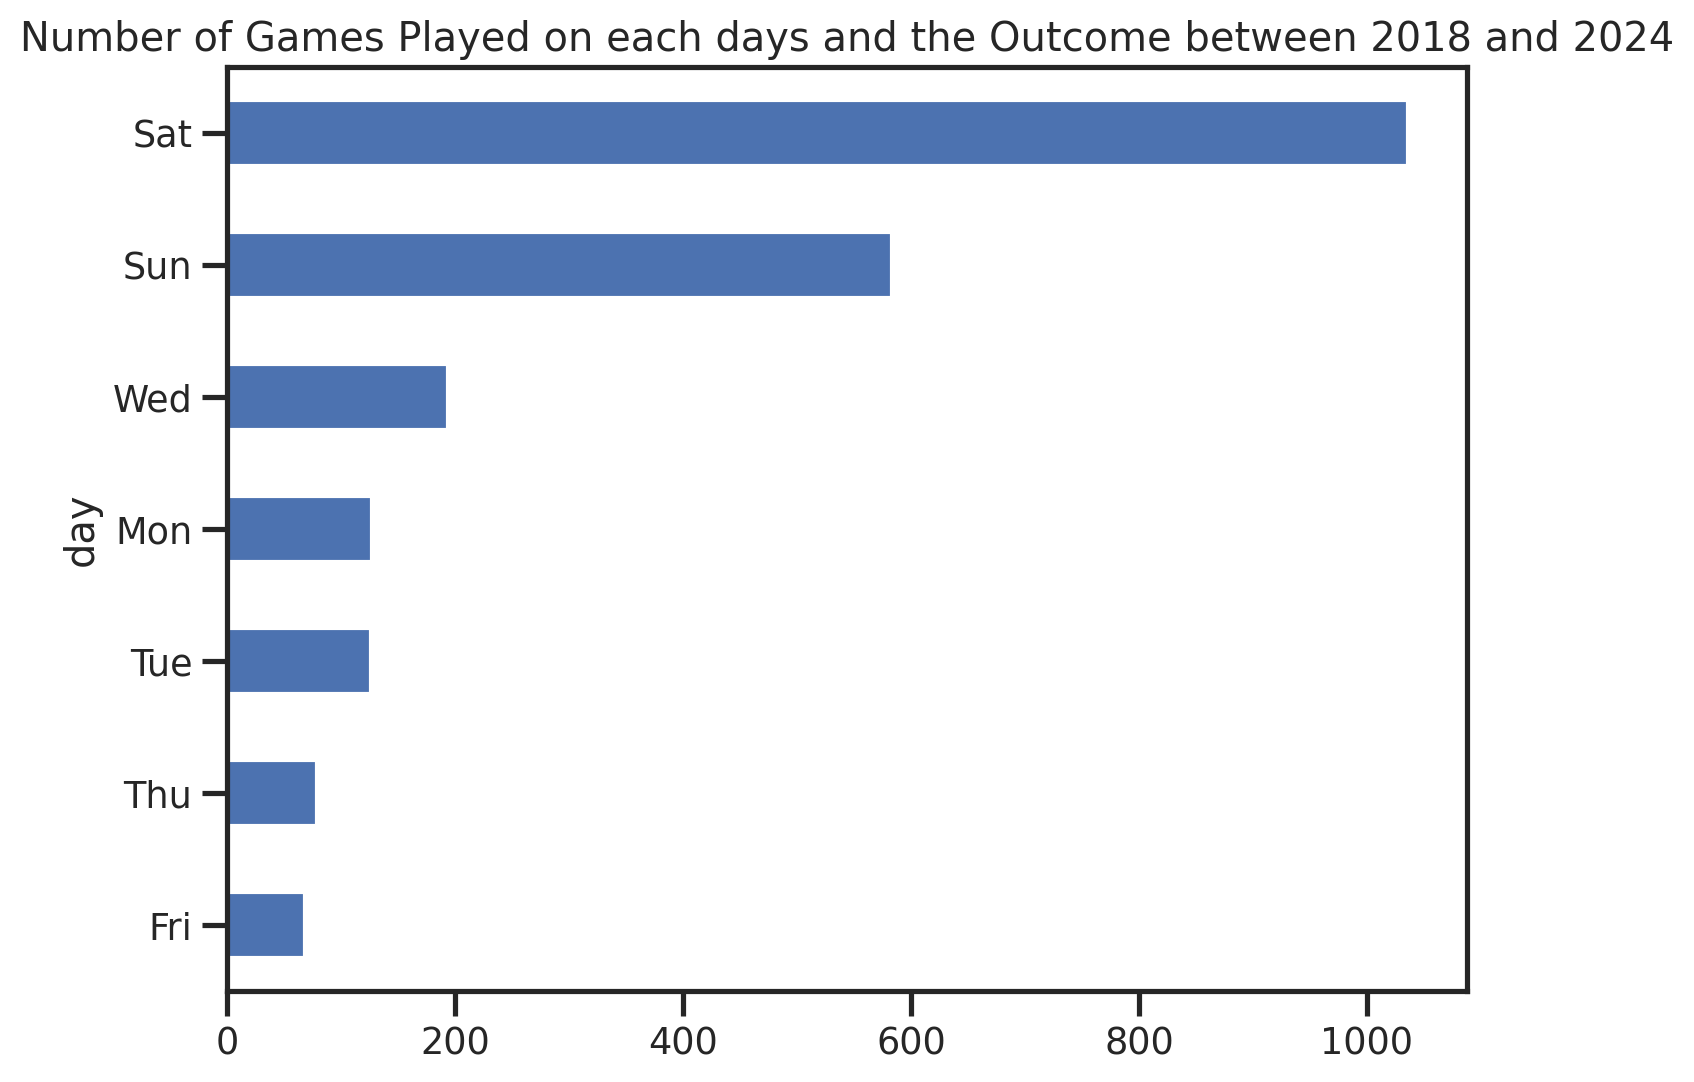

In [26]:
count_days.sort_values(ascending=True).plot(kind="barh", title="Number of Games Played on each days and the Outcome between 2018 and 2024");

### Captains

In [27]:
captain_count = matches['captain'].value_counts()/2
len(captain_count.index[0])

10

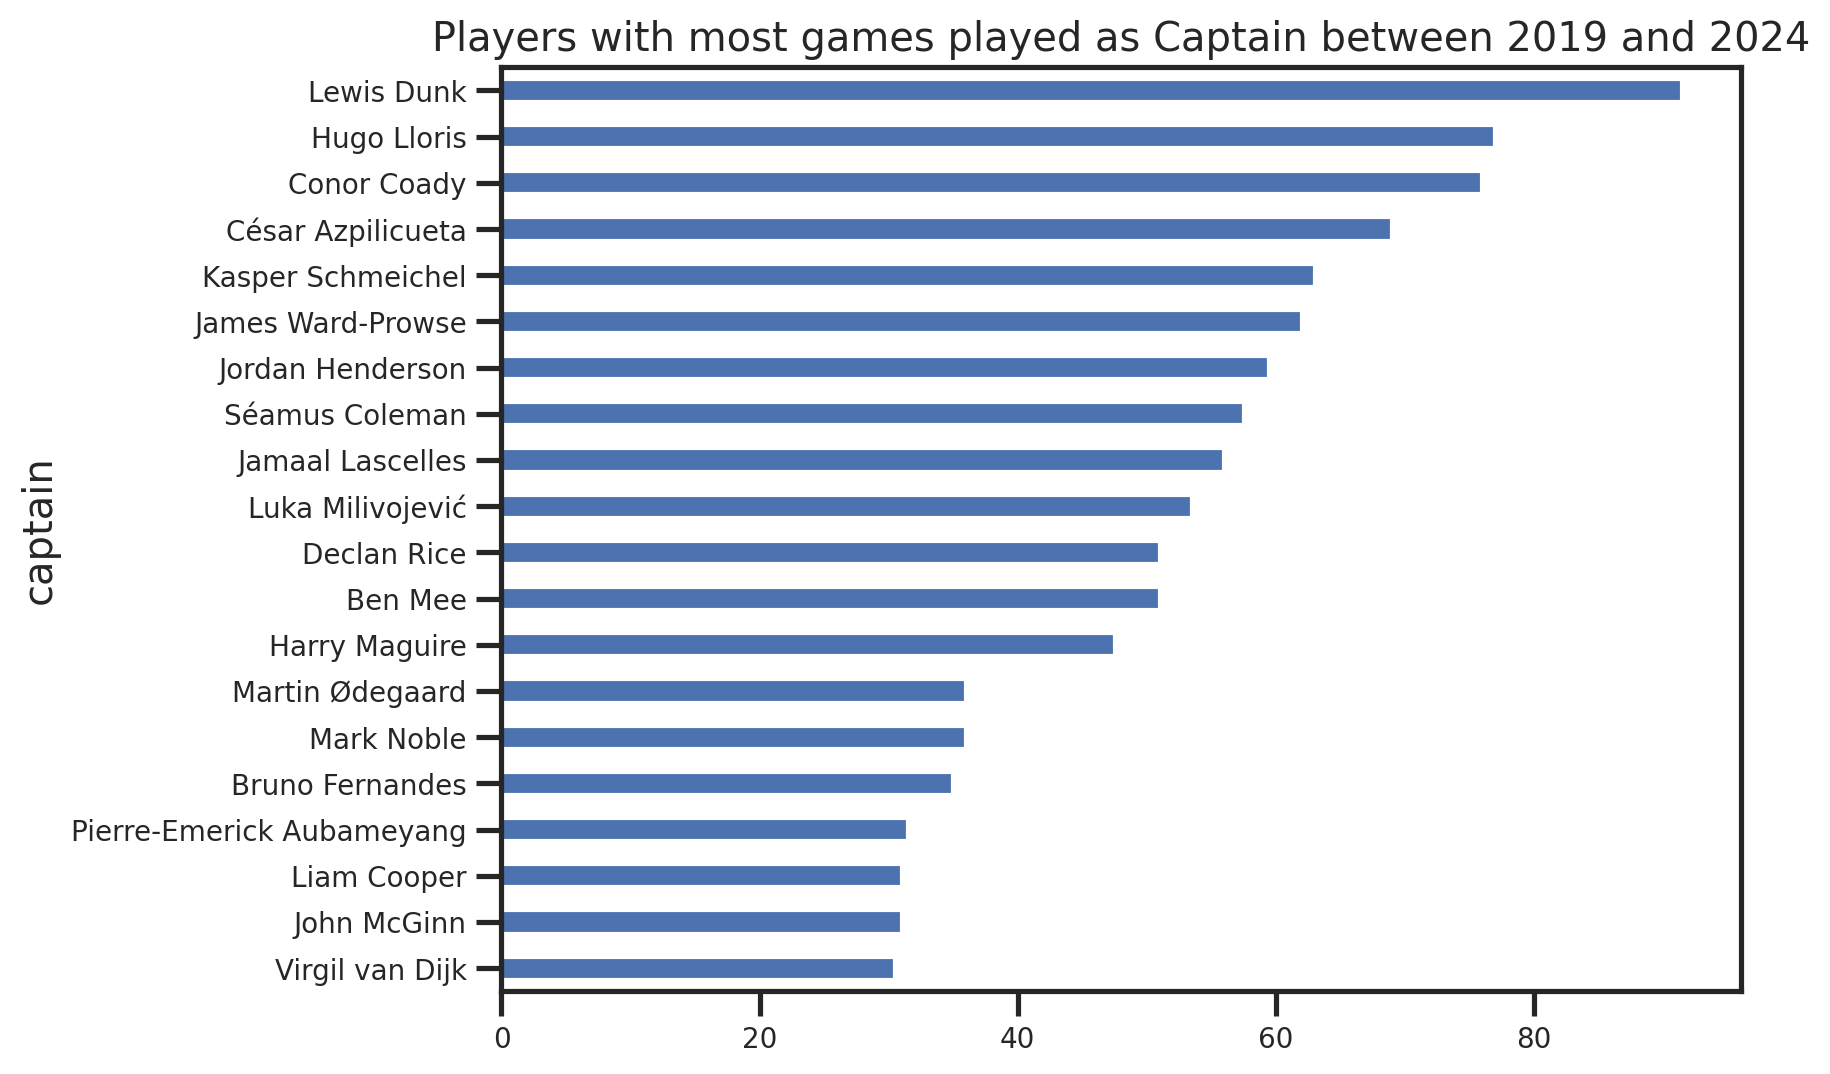

In [28]:
captain_count[:20].sort_values(ascending=True).plot(kind='barh',title= "Players with most games played as Captain between 2019 and 2024", fontsize=10);

In [29]:
print(len(matches[matches['captain'].str.contains('Bruno Fernandes')]))
print(len(matches[matches['captain'].str.contains('Harry Maguire')]))

70
95


In [30]:
print(f"Bruno Fernandes's Caps: {matches[matches['captain'].str.contains('Bruno Fernandes')]['season'].unique()}")
print(f"Harry Maguire's Caps: {matches[matches['captain'].str.contains('Harry Maguire')]['season'].unique()}")

Bruno Fernandes's Caps: [2024 2023 2022 2021]
Harry Maguire's Caps: [2023 2022 2021 2020]


I'm a Manchester united fan, it's time I compare Bruno's and Maguire's Match results as captains

In [31]:
bruno_maguire_caps = matches[(matches['captain'].str.contains('Bruno Fernandes')) | (matches['captain'].str.contains('Harry Maguire'))]

In [32]:
bruno_maguire_caps.groupby('captain')['result'].value_counts()

captain          result
Bruno Fernandes  W         34
                 L         21
                 D         15
Harry Maguire    W         53
                 D         23
                 L         19
Name: count, dtype: int64

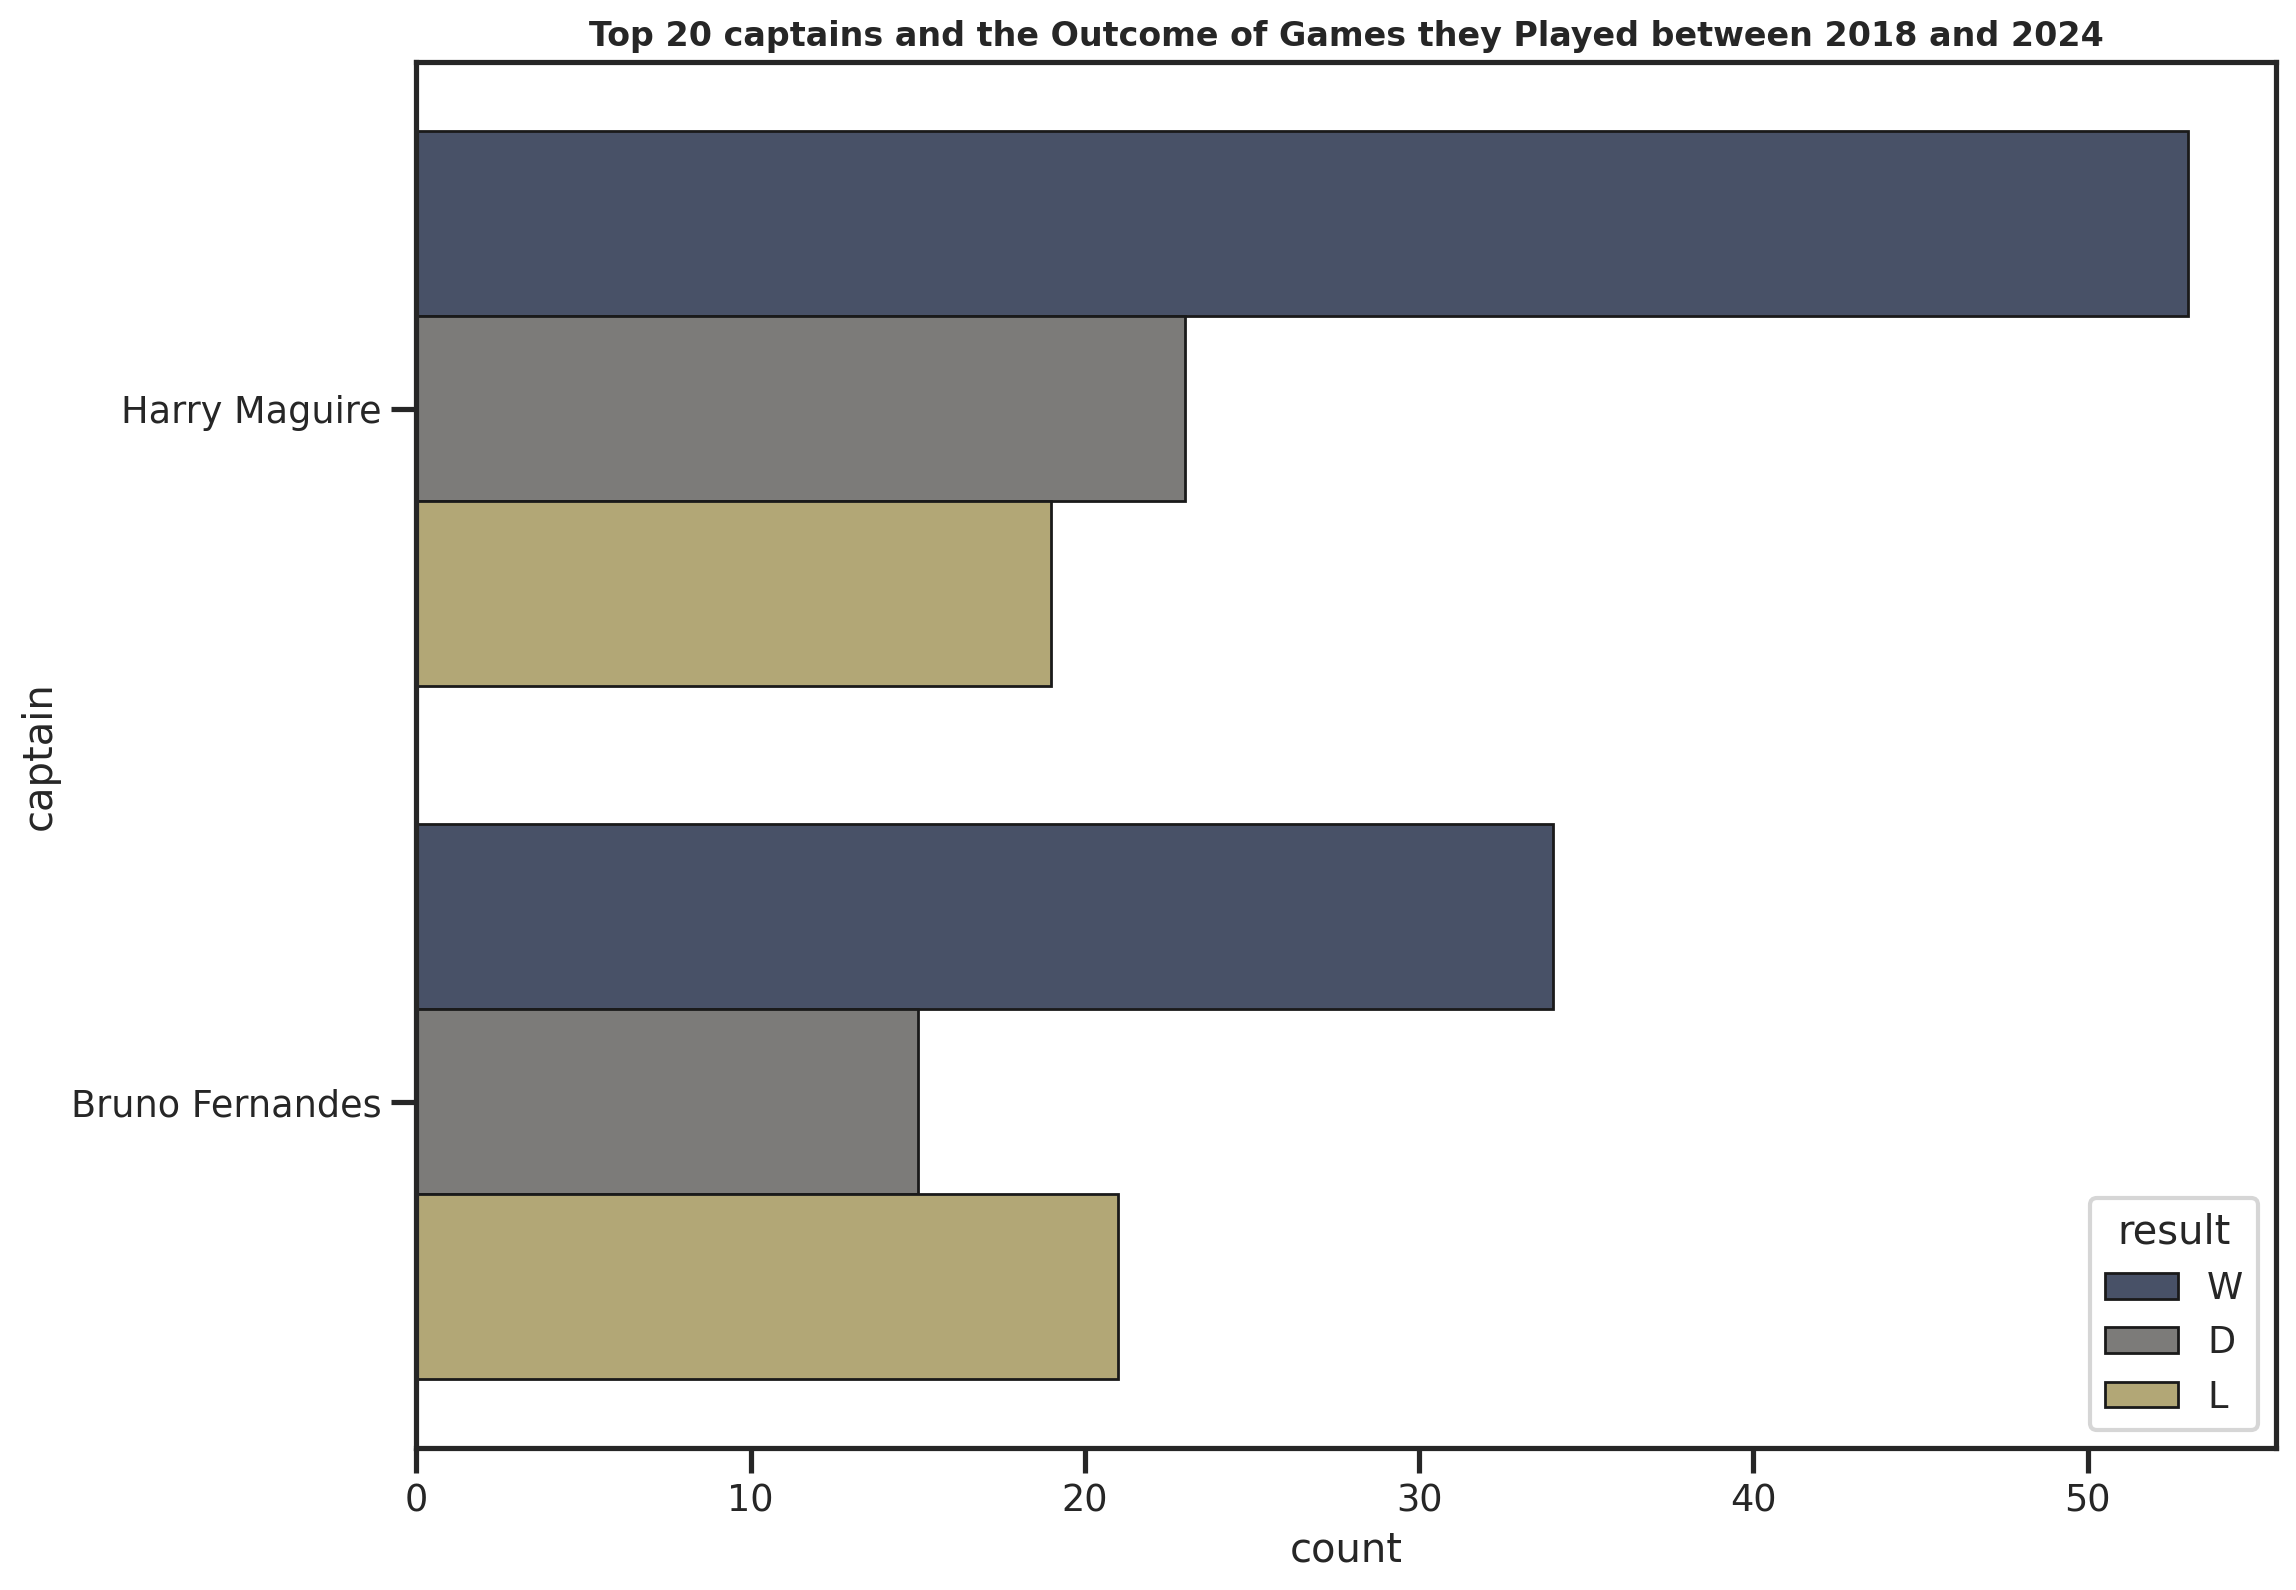

In [33]:
plot_countplot(bruno_maguire_caps, bruno_maguire_caps['captain'].value_counts(), "captain", "Top 20 captains and the Outcome of Games they Played between 2018 and 2024", matches['result'])

### Total Shots

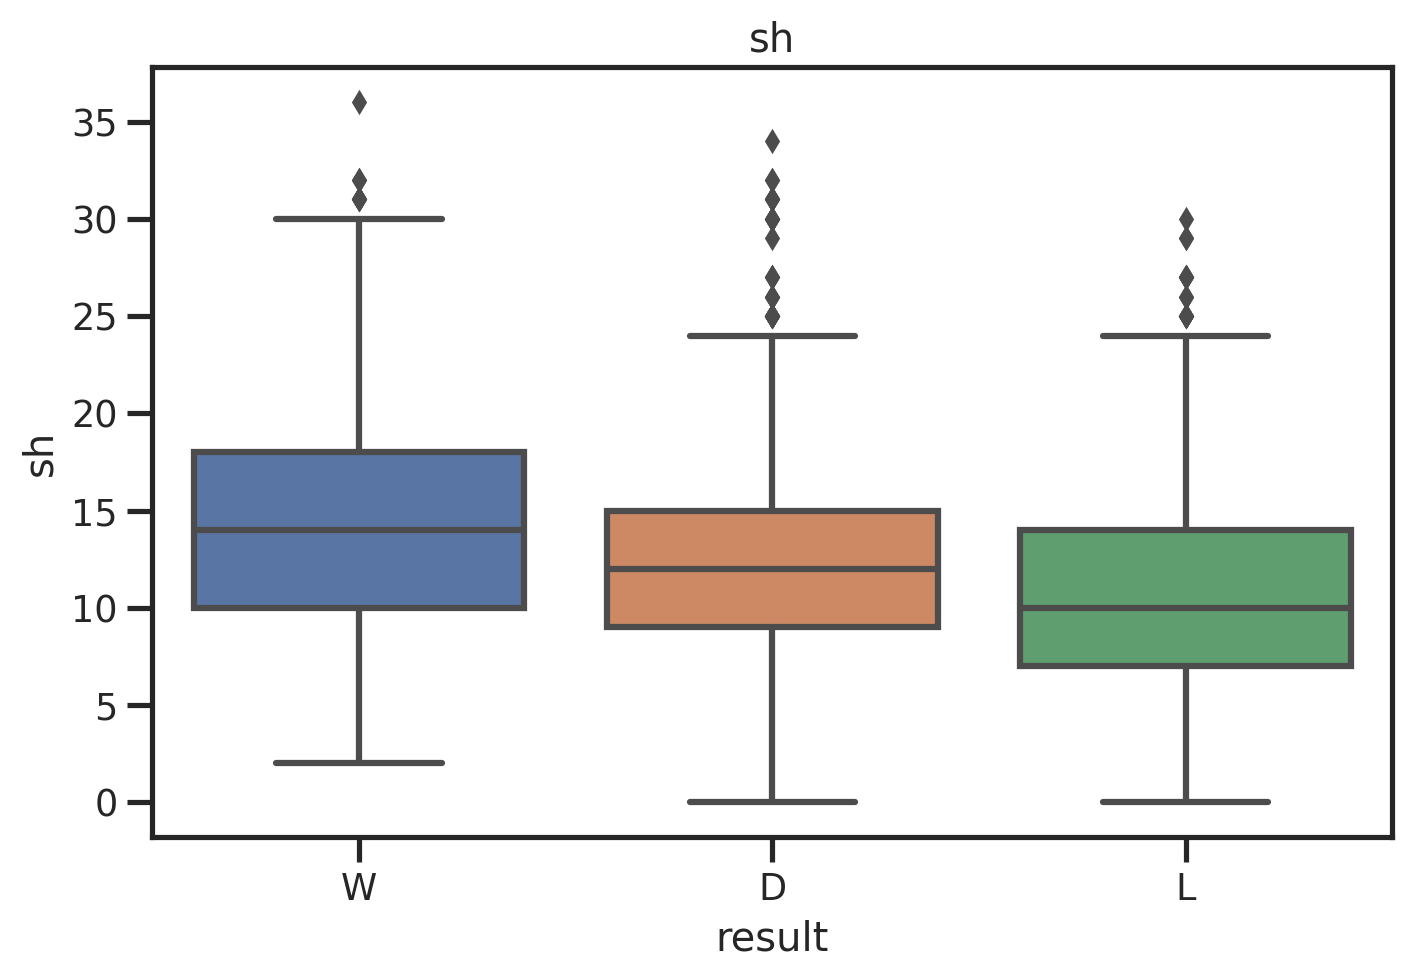

In [34]:
plot_boxplot(matches, 'sh', 'result')

### Shots on target

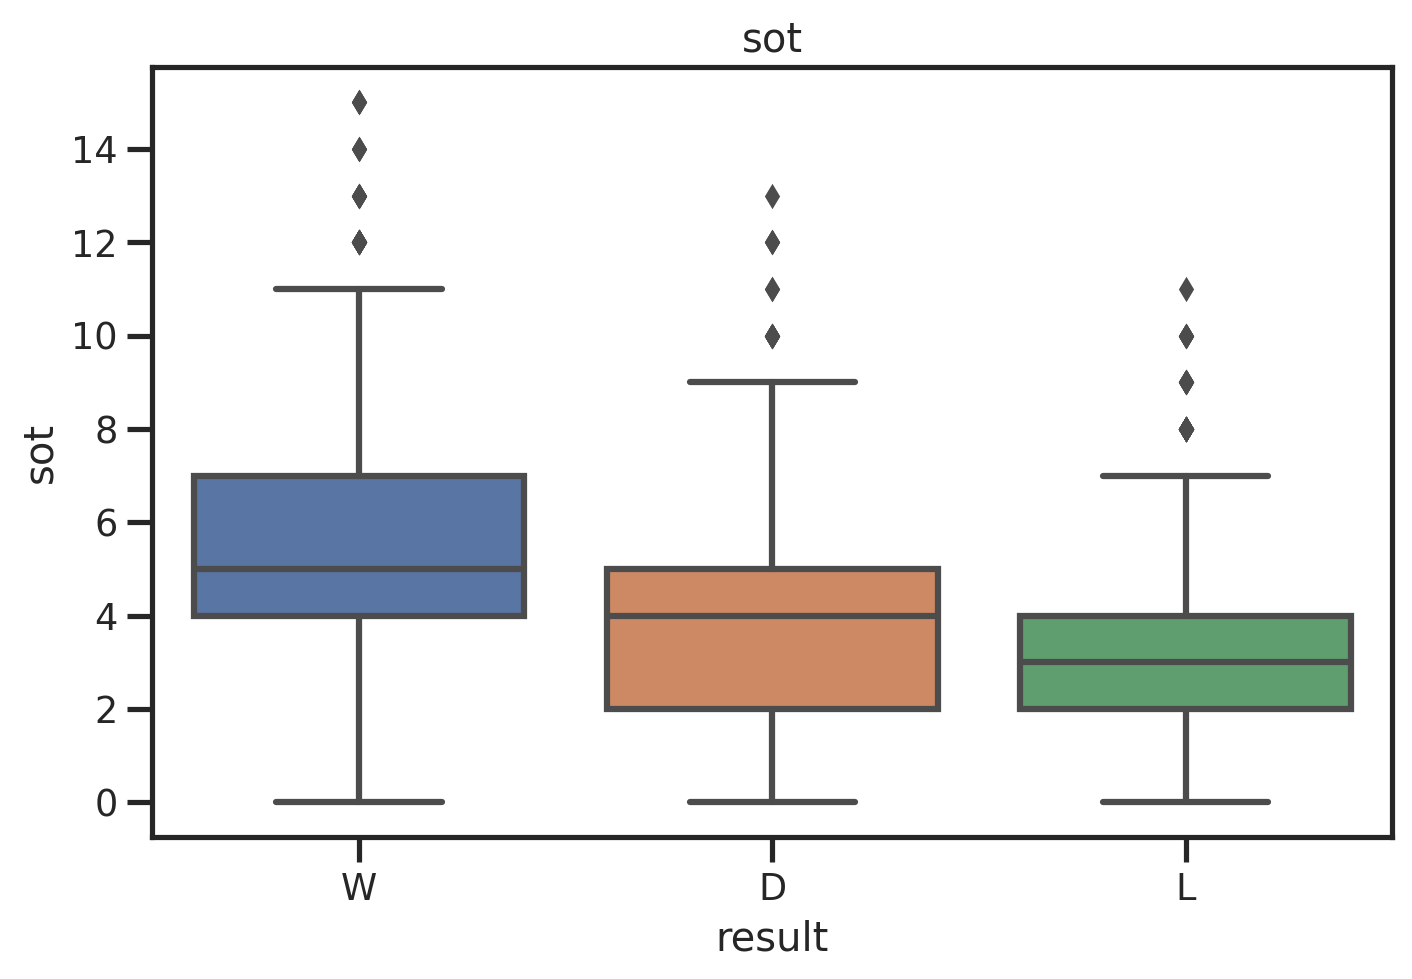

In [35]:
plot_boxplot(matches, 'sot', 'result')

let's check all columns if they need cleaning before contiuing the EDA

In [36]:
matches.dtypes

date          object
time          object
day           object
venue         object
result        object
gf           float64
ga           float64
opponent      object
xg           float64
xga          float64
poss         float64
captain       object
formation     object
referee       object
sh           float64
sot          float64
fk           float64
pk             int64
pkatt          int64
season         int64
team          object
dtype: object

In [37]:
# Convert 'date' column to datetime
matches['date'] = pd.to_datetime(matches['date'])

In [38]:
matches['time']

0       12:30
1       20:00
2       15:00
3       16:30
4       16:30
        ...  
4421    12:30
4422    15:00
4423    20:00
4424    14:00
4425    15:00
Name: time, Length: 4426, dtype: object

In [39]:
# Convert 'time' column to datetime
matches['time'] = pd.to_datetime(matches['time'], format='%H:%M').dt.time

In [40]:
matches['time']

0       12:30:00
1       20:00:00
2       15:00:00
3       16:30:00
4       16:30:00
          ...   
4421    12:30:00
4422    15:00:00
4423    20:00:00
4424    14:00:00
4425    15:00:00
Name: time, Length: 4426, dtype: object

In [41]:
matches['day'].unique()

array(['Sat', 'Mon', 'Sun', 'Tue', 'Thu', 'Wed', 'Fri'], dtype=object)

In [42]:
matches['venue'].unique()

array(['Home', 'Away'], dtype=object)

In [43]:
print(matches['gf'].unique())
matches['gf'] = matches['gf'].astype(int)

[2. 1. 3. 4. 5. 0. 6. 8. 9. 7.]


In [44]:
print(matches['ga'].unique())
matches['ga'] = matches['ga'].astype(int)

[1. 0. 2. 3. 4. 5. 6. 8. 7. 9.]


Renaming team names to match the team column

In [45]:
[i for i in sorted(matches['opponent'].unique()) if i not in sorted(matches['team'].unique())]

['Brighton',
 'Huddersfield',
 'Manchester Utd',
 'Newcastle Utd',
 "Nott'ham Forest",
 'Sheffield Utd',
 'Tottenham',
 'West Brom',
 'West Ham',
 'Wolves']

In [46]:
[i for i in sorted(matches['team'].unique()) if i not in sorted(matches['opponent'].unique())]

['Brighton and Hove Albion',
 'Huddersfield Town',
 'Manchester United',
 'Newcastle United',
 'Nottingham Forest',
 'Sheffield United',
 'Tottenham Hotspur',
 'West Bromwich Albion',
 'West Ham United',
 'Wolverhampton Wanderers']

In [47]:
matches['opponent'].replace(['Brighton','Manchester Utd', 'Huddersfield','Newcastle Utd',"Nott'ham Forest",'Sheffield Utd','Tottenham','West Brom','West Ham','Wolves'],
                            ['Brighton and Hove Albion','Manchester United', 'Huddersfield Town', 'Newcastle United','Nottingham Forest','Sheffield United','Tottenham Hotspur',
                             'West Bromwich Albion','West Ham United','Wolverhampton Wanderers'], inplace=True)

In [48]:
matches['opponent'].unique()

array(['Nottingham Forest', 'Crystal Palace', 'Fulham',
       'Manchester United', 'Everton', 'Tottenham Hotspur', 'Bournemouth',
       'Manchester City', 'Chelsea', 'Sheffield United',
       'Newcastle United', 'Burnley', 'Brentford',
       'Wolverhampton Wanderers', 'Luton Town', 'Aston Villa',
       'Brighton and Hove Albion', 'Liverpool', 'West Ham United',
       'Arsenal', 'Southampton', 'Leicester City', 'Leeds United',
       'Norwich City', 'Watford', 'West Bromwich Albion',
       'Huddersfield Town', 'Cardiff City'], dtype=object)

In [49]:
matches['xg'].unique()

array([0.8, 2. , 3.2, 2.3, 1. , 1.8, 3.4, 0.4, 2.8, 0.6, 1.6, 2.2, 1.4,
       0.7, 2.7, 3.3, 1.2, 3.5, 3.6, 1.3, 3. , 0.9, 2.5, 2.6, 1.7, 2.1,
       7. , 1.5, 2.9, 1.9, 0.5, 4. , 2.4, 1.1, 3.8, 4.1, 0.2, 0.3, 3.9,
       3.1, 4.2, 3.7, 0.1, 0. , 4.3, 4.4, 5.2, 4.6, 5.9, 4.7, 4.8, 4.5])

In [50]:
matches['xga'].unique()

array([1.2, 1. , 0.6, 0.9, 0.3, 1.4, 0.5, 1.3, 0. , 1.1, 0.7, 0.4, 0.2,
       2. , 2.2, 2.3, 0.1, 0.8, 1.6, 1.7, 3.5, 2.9, 1.8, 2.7, 2.1, 4.1,
       2.6, 3.2, 1.5, 3.3, 2.5, 3.4, 4. , 2.4, 3. , 3.6, 1.9, 2.8, 3.8,
       7. , 3.1, 3.7, 4.2, 3.9, 5.2, 4.4, 4.3, 5.9, 4.6, 4.7, 4.8, 4.5])

In [51]:
print(matches['poss'].unique())
matches['poss'] = matches['poss'].astype(int)

[78. 53. 71. 55. 74. 47. 57. 49. 56. 67. 58. 63. 66. 61. 48. 73. 60. 43.
 70. 64. 80. 28. 46. 35. 41. 65. 36. 54. 77. 72. 75. 76. 68. 52. 50. 62.
 69. 82. 59. 79. 51. 40. 45. 37. 39. 38. 32. 33. 44. 42. 27. 25. 22. 26.
 30. 31. 34. 29. 23. 24. 21. 20. 18. 81. 19.]


In [52]:
matches[~(matches['captain'].str.contains('^[a-zA-Z0-9]'))]['captain'].unique()

array(['İlkay Gündoğan', 'Étienne Capoue'], dtype=object)

In [53]:
matches['formation'].unique()

array(['4-3-3', '4-2-3-1', '3-2-4-1', '3-4-3', '4-1-4-1', '4-4-2',
       '4-2-2-2', '4-4-1-1', '3-5-2', '5-3-2', '4-1-2-1-2◆', '4-2-4-0',
       '4-3-2-1', '4-5-1', '4-3-1-2', '5-4-1', '3-4-1-2', '3-5-1-1',
       '3-4-3◆', '3-3-3-1', '3-1-4-2', '4-1-3-2'], dtype=object)

In [54]:
matches[matches['formation'].str.contains('4-1-2-1-2◆')]

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,captain,formation,referee,sh,sot,fk,pk,pkatt,season,team
160,2023-09-16,15:00:00,Sat,Home,L,1,3,Brighton and Hove Albion,1.0,1.7,...,Bruno Fernandes,4-1-2-1-2◆,Jarred Gillett,14.0,4.0,1.0,0,0,2024,Manchester United
298,2023-12-28,19:30:00,Thu,Home,W,4,2,Tottenham Hotspur,3.2,2.3,...,Lewis Dunk,4-1-2-1-2◆,Jarred Gillett,13.0,7.0,0.0,2,2,2024,Brighton and Hove Albion
789,2022-10-29,19:45:00,Sat,Home,L,1,2,Leeds United,1.7,1.8,...,Virgil van Dijk,4-1-2-1-2◆,Michael Oliver,22.0,10.0,0.0,0,0,2023,Liverpool
790,2022-11-06,16:30:00,Sun,Away,W,2,1,Tottenham Hotspur,1.2,1.2,...,Virgil van Dijk,4-1-2-1-2◆,Andy Madley,13.0,6.0,0.0,0,0,2023,Liverpool
795,2023-01-14,15:00:00,Sat,Away,L,0,3,Brighton and Hove Albion,1.0,1.9,...,Jordan Henderson,4-1-2-1-2◆,Darren England,6.0,2.0,0.0,0,0,2023,Liverpool
855,2022-08-13,12:30:00,Sat,Home,W,2,1,Everton,2.3,1.6,...,John McGinn,4-1-2-1-2◆,Michael Oliver,12.0,3.0,0.0,0,0,2023,Aston Villa
1503,2021-09-11,12:30:00,Sat,Away,L,0,3,Crystal Palace,0.1,2.1,...,Hugo Lloris,4-1-2-1-2◆,Jonathan Moss,2.0,1.0,0.0,0,0,2022,Tottenham Hotspur
1706,2021-12-26,20:00:00,Sun,Home,W,2,0,Brentford,0.8,0.7,...,Adam Lallana,4-1-2-1-2◆,Darren England,15.0,5.0,3.0,0,0,2022,Brighton and Hove Albion
1709,2022-01-14,20:00:00,Fri,Home,D,1,1,Crystal Palace,2.0,0.2,...,Adam Lallana,4-1-2-1-2◆,Robert Jones,18.0,3.0,0.0,0,1,2022,Brighton and Hove Albion
1711,2022-01-23,14:00:00,Sun,Away,D,1,1,Leicester City,1.1,1.4,...,Adam Webster,4-1-2-1-2◆,Martin Atkinson,14.0,4.0,0.0,0,0,2022,Brighton and Hove Albion


In [55]:
matches['formation'].replace(["4-1-2-1-2◆","3-4-3◆","4-2-4-0"], ["4-1-2-1-2", "3-4-3", "4-2-4"], inplace=True)

In [56]:
matches['formation'].unique()

array(['4-3-3', '4-2-3-1', '3-2-4-1', '3-4-3', '4-1-4-1', '4-4-2',
       '4-2-2-2', '4-4-1-1', '3-5-2', '5-3-2', '4-1-2-1-2', '4-2-4',
       '4-3-2-1', '4-5-1', '4-3-1-2', '5-4-1', '3-4-1-2', '3-5-1-1',
       '3-3-3-1', '3-1-4-2', '4-1-3-2'], dtype=object)

In [57]:
matches.groupby('formation')['result'].value_counts().sort_values(ascending=False)[:20]

formation  result
4-2-3-1    W         503
4-3-3      W         486
4-2-3-1    L         439
4-3-3      L         264
4-2-3-1    D         246
4-4-2      L         239
4-3-3      D         203
3-4-3      W         191
           L         182
4-4-2      W         173
           D         132
3-5-2      L         121
3-4-3      D         112
4-1-4-1    L         102
4-4-1-1    L          91
4-1-4-1    W          71
3-5-2      W          67
5-4-1      L          58
3-5-2      D          57
4-1-4-1    D          56
Name: count, dtype: int64

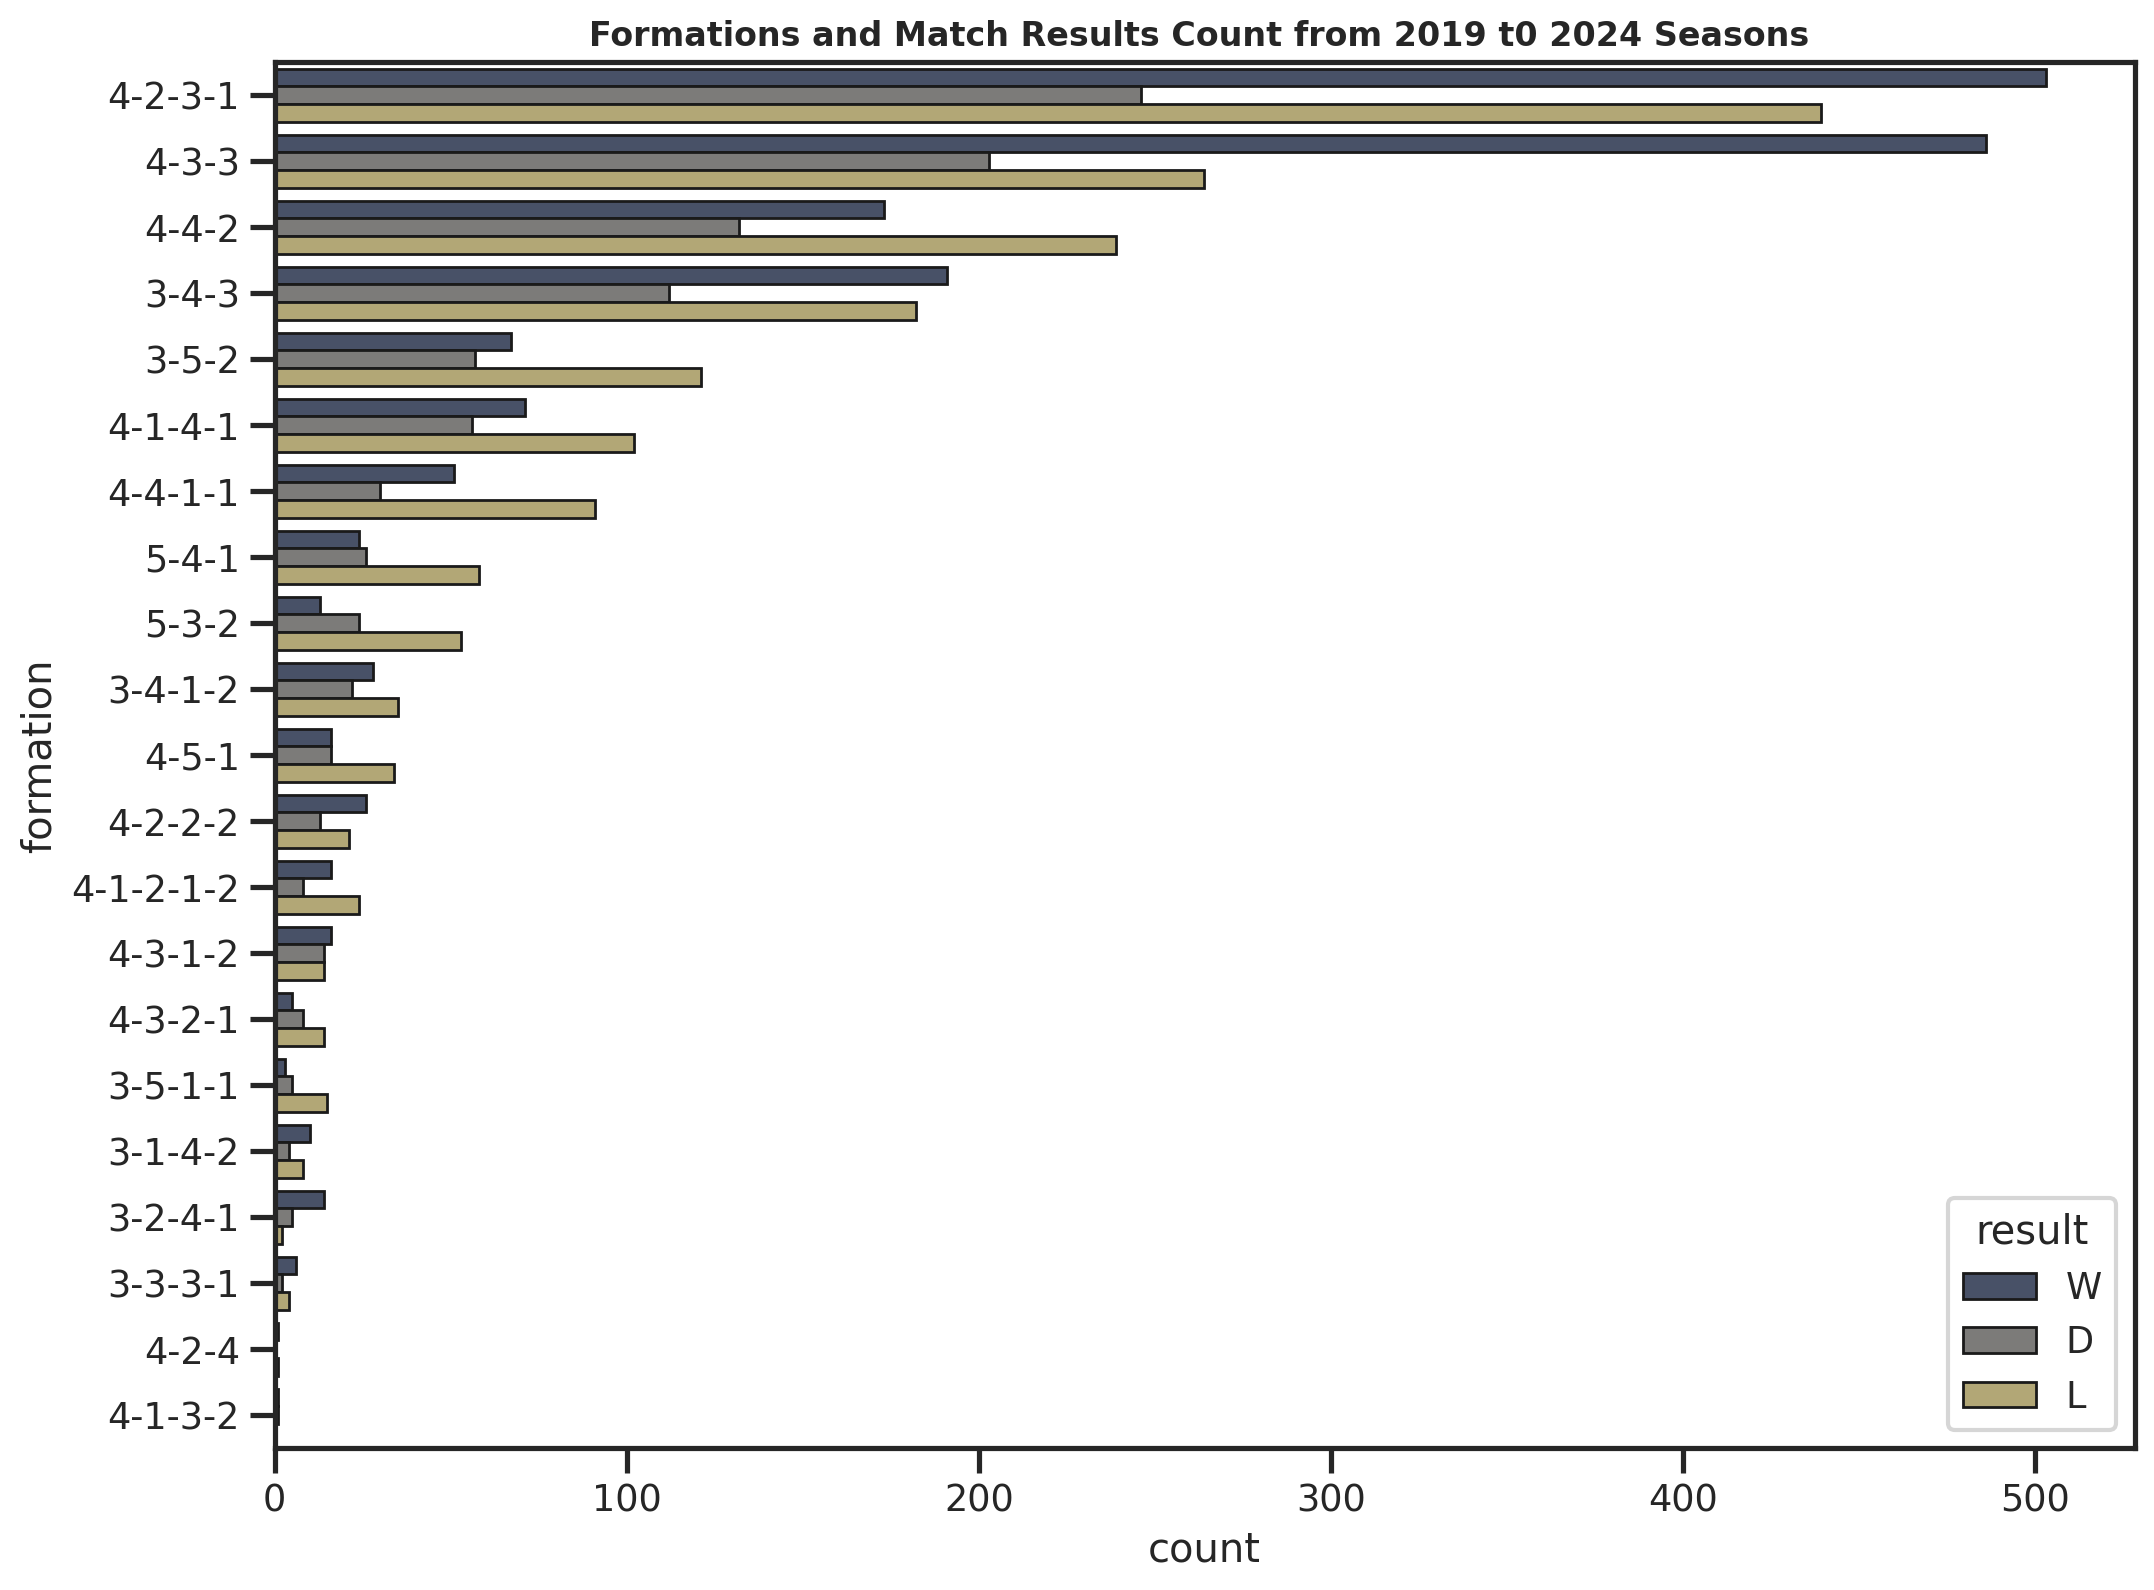

In [58]:
plot_countplot(matches, matches['formation'].value_counts(), 'formation', 'Formations and Match Results Count from 2019 t0 2024 Seasons ', matches['result'])

In [59]:
matches['referee'].unique()

array(['Michael Oliver', 'David Coote', 'Paul Tierney', 'Anthony Taylor',
       'Simon Hooper', 'Robert Jones', 'Michael Salisbury',
       'Chris Kavanagh', 'Tim Robinson', 'Stuart Attwell', 'Peter Bankes',
       'Samuel Barrott', 'Jarred Gillett', 'Joshua Smith', 'Craig Pawson',
       'John Brooks', 'Thomas Bramall', 'Andy Madley', 'Darren England',
       'Lewis Smith', 'Tony Harrington', 'Graham Scott', 'Samuel Allison',
       'Darren Bond', 'Robert Madley', 'Rebecca Welch', 'Sunny Singh',
       'Andre Marriner', 'Martin Atkinson', 'Jonathan Moss',
       'Kevin Friend', 'Mike Dean', 'Lee Mason', 'Oliver Langford',
       'Lee Probert', 'Roger East'], dtype=object)

In [60]:
refree_count = matches['referee'].value_counts()/2

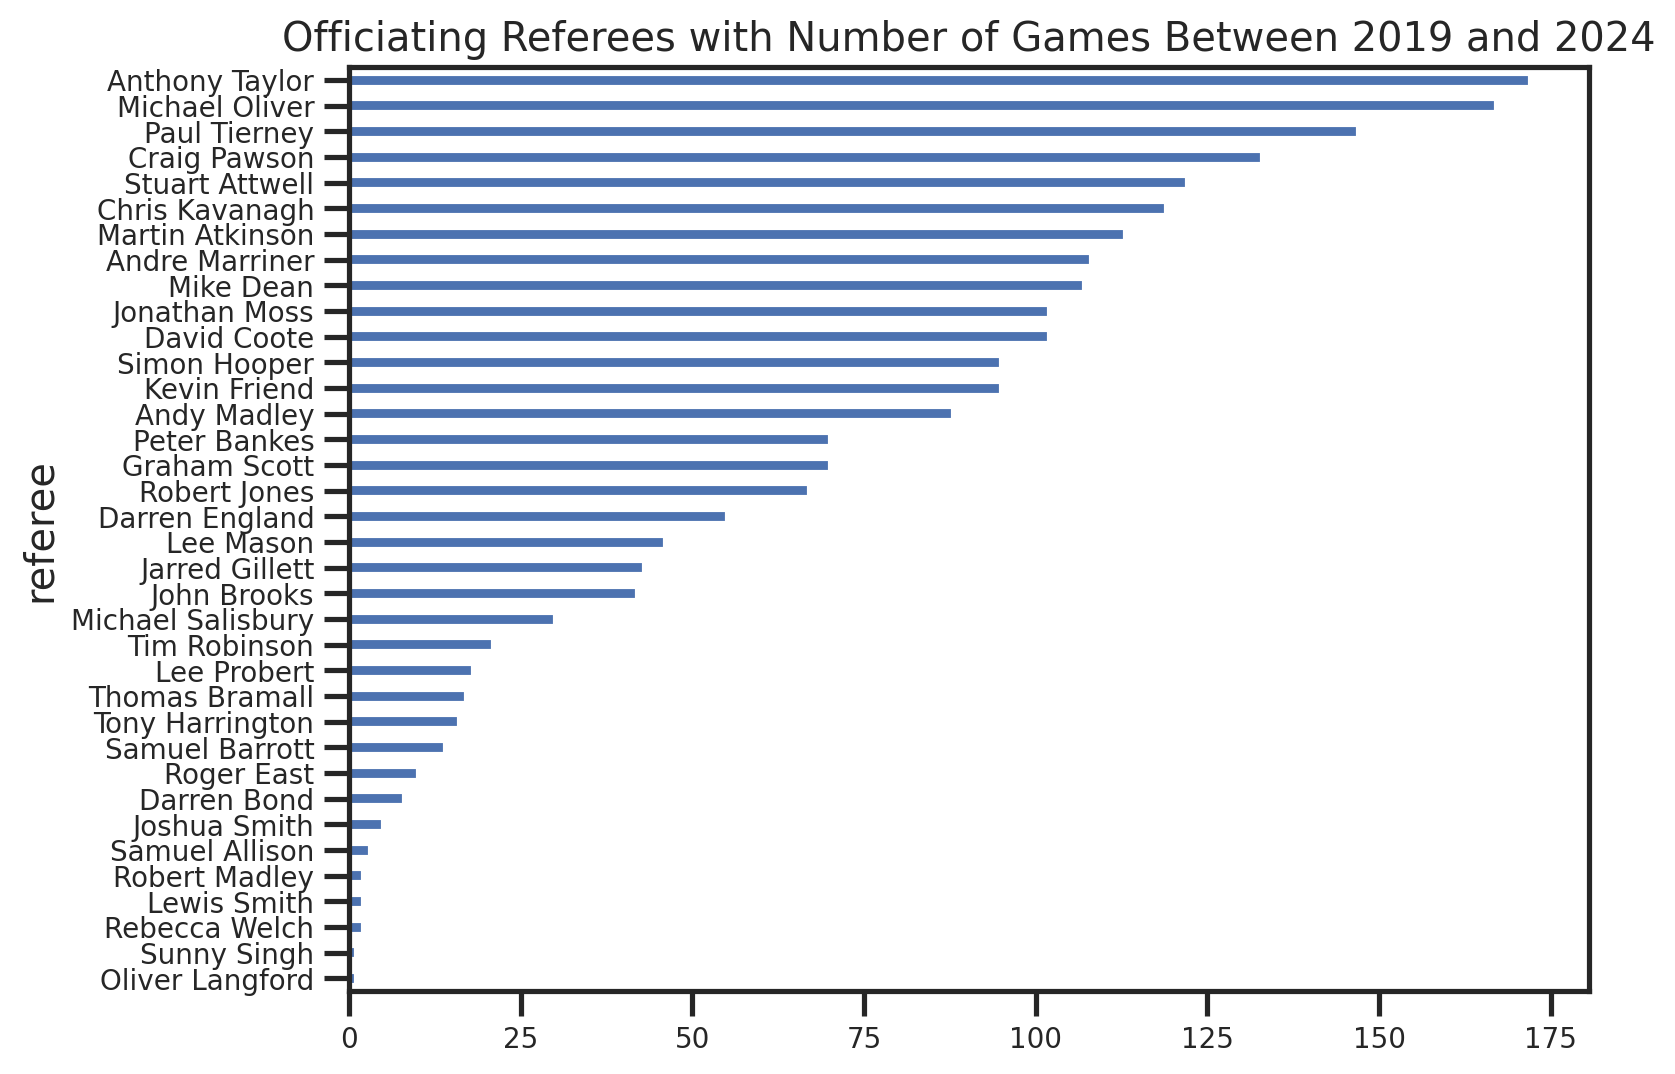

In [61]:
refree_count.sort_values(ascending=True).plot(kind='barh',fontsize=10, title="Officiating Referees with Number of Games Between 2019 and 2024");

In [62]:
print(matches['sh'].unique())
matches['sh'] = matches['sh'].astype(int)

[15. 13. 18. 17. 12. 14. 16. 19. 23. 26. 30. 21. 24. 22.  6. 25.  9.  8.
 34. 32. 27. 10. 29.  7.  4. 20.  2. 31. 28. 11.  3.  5.  1.  0. 36.]


In [63]:
print(matches['sot'].unique())
matches['sot'] = matches['sot'].astype(int)

[ 7.  2.  9.  5.  4.  6.  3.  1.  8. 11. 10. 12. 13.  0. 15. 14.]


In [64]:
print(matches['fk'].unique())
matches['fk'] = matches['fk'].astype(int)

[0. 1. 2. 3. 4.]


In [65]:
print(matches['pk'].unique())

[0 1 2 3]


In [66]:
print(matches['pkatt'].unique())

[0 1 2 3]


In [67]:
# check if each value in both columns are equal at each index
{True for i, j in zip(matches['pk'], matches['pkatt']) if i == j}

{True}

In [68]:
# drop pk column
matches.drop(columns='pk', inplace=True)
matches.shape

(4426, 20)

In [69]:
matches['season'].unique()

array([2024, 2023, 2022, 2021, 2020, 2019])

Create a total goals column and a year column

In [70]:
matches['total_goals'] = matches['ga'] + matches['gf']

In [71]:
matches['year'] = matches['date'].apply(lambda x: x.strftime('%Y'))

In [72]:
x = matches.query("year=='2023'")
x.query("opponent=='Nottingham Forest'").iloc[0].to_frame().T

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,formation,referee,sh,sot,fk,pkatt,season,team,total_goals,year
0,2023-08-12 00:00:00,12:30:00,Sat,Home,W,2,1,Nottingham Forest,0.8,1.2,...,4-3-3,Michael Oliver,15,7,0,0,2024,Arsenal,3,2023


In [73]:
year_count = (matches['year'].value_counts() / 2).to_frame().reset_index()
year_count

,year,count
0,2023,412.0
1,2021,408.0
2,2019,379.0
3,2022,361.0
4,2020,336.0
5,2018,200.0
6,2024,117.0


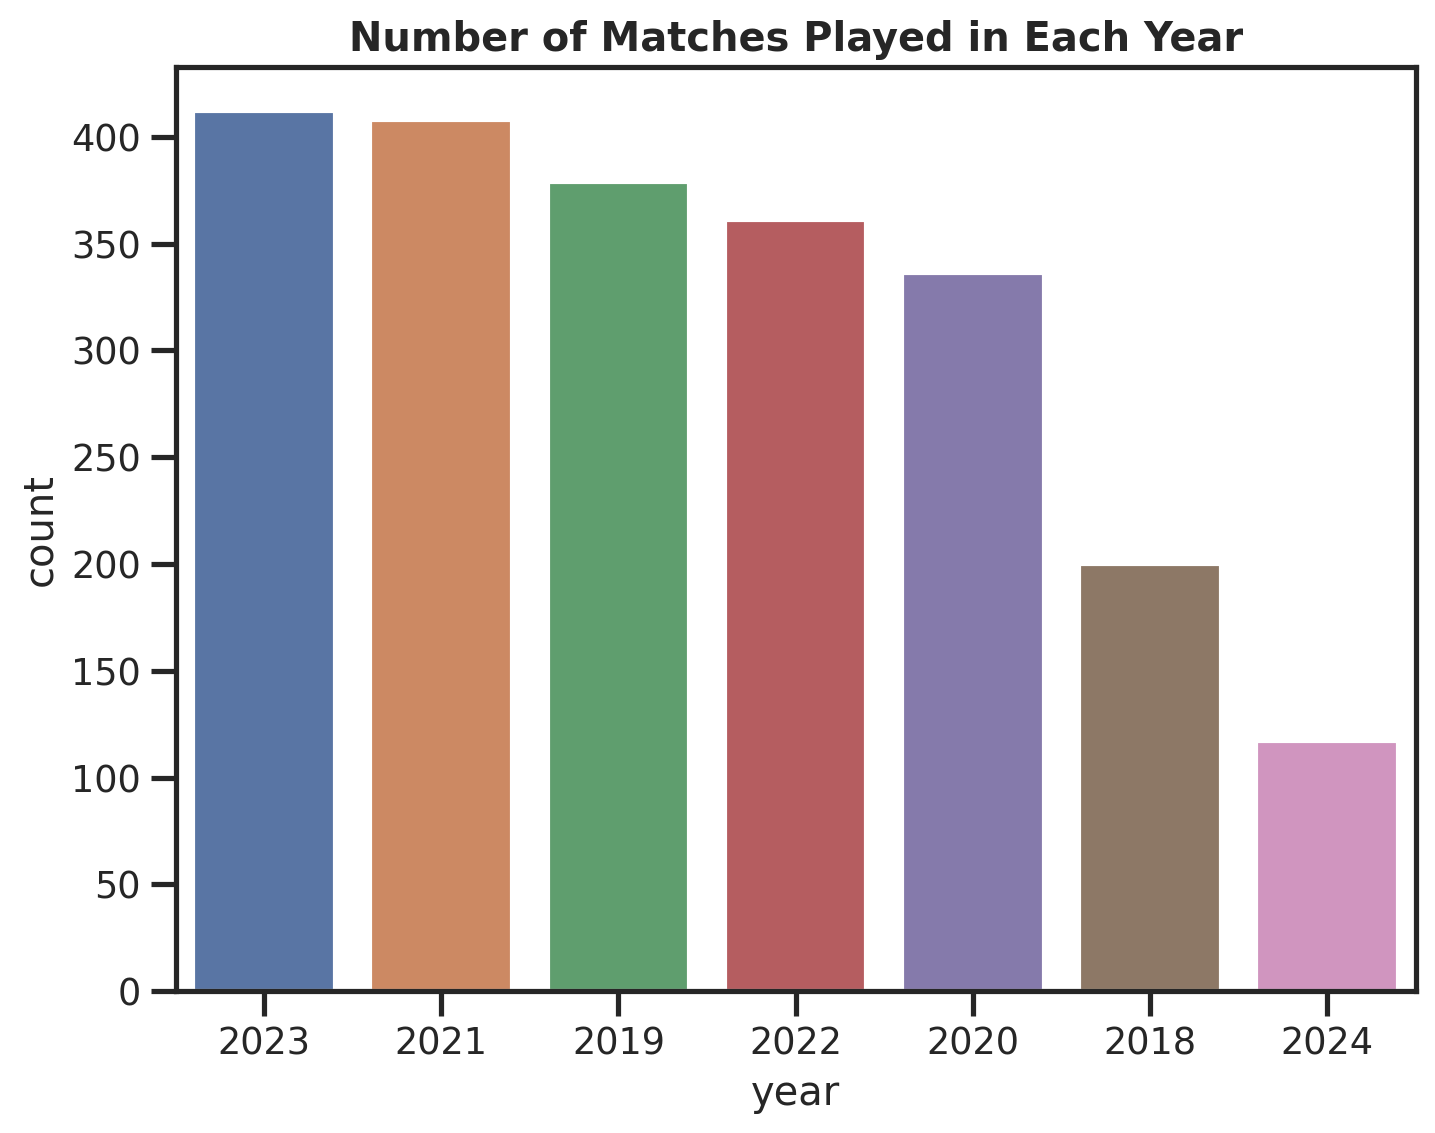

In [74]:
sns.barplot(x='year', y='count', data=year_count)
plt.title('Number of Matches Played in Each Year', weight='bold');

In [75]:
goals_per_year = (matches.groupby('year')['total_goals'].sum()/ 2).to_frame().reset_index()
goals_per_year

,year,total_goals
0,2018,569.0
1,2019,1062.0
2,2020,909.0
3,2021,1108.0
4,2022,1025.0
5,2023,1222.0
6,2024,403.0


<Axes: xlabel='year', ylabel='total_goals'>

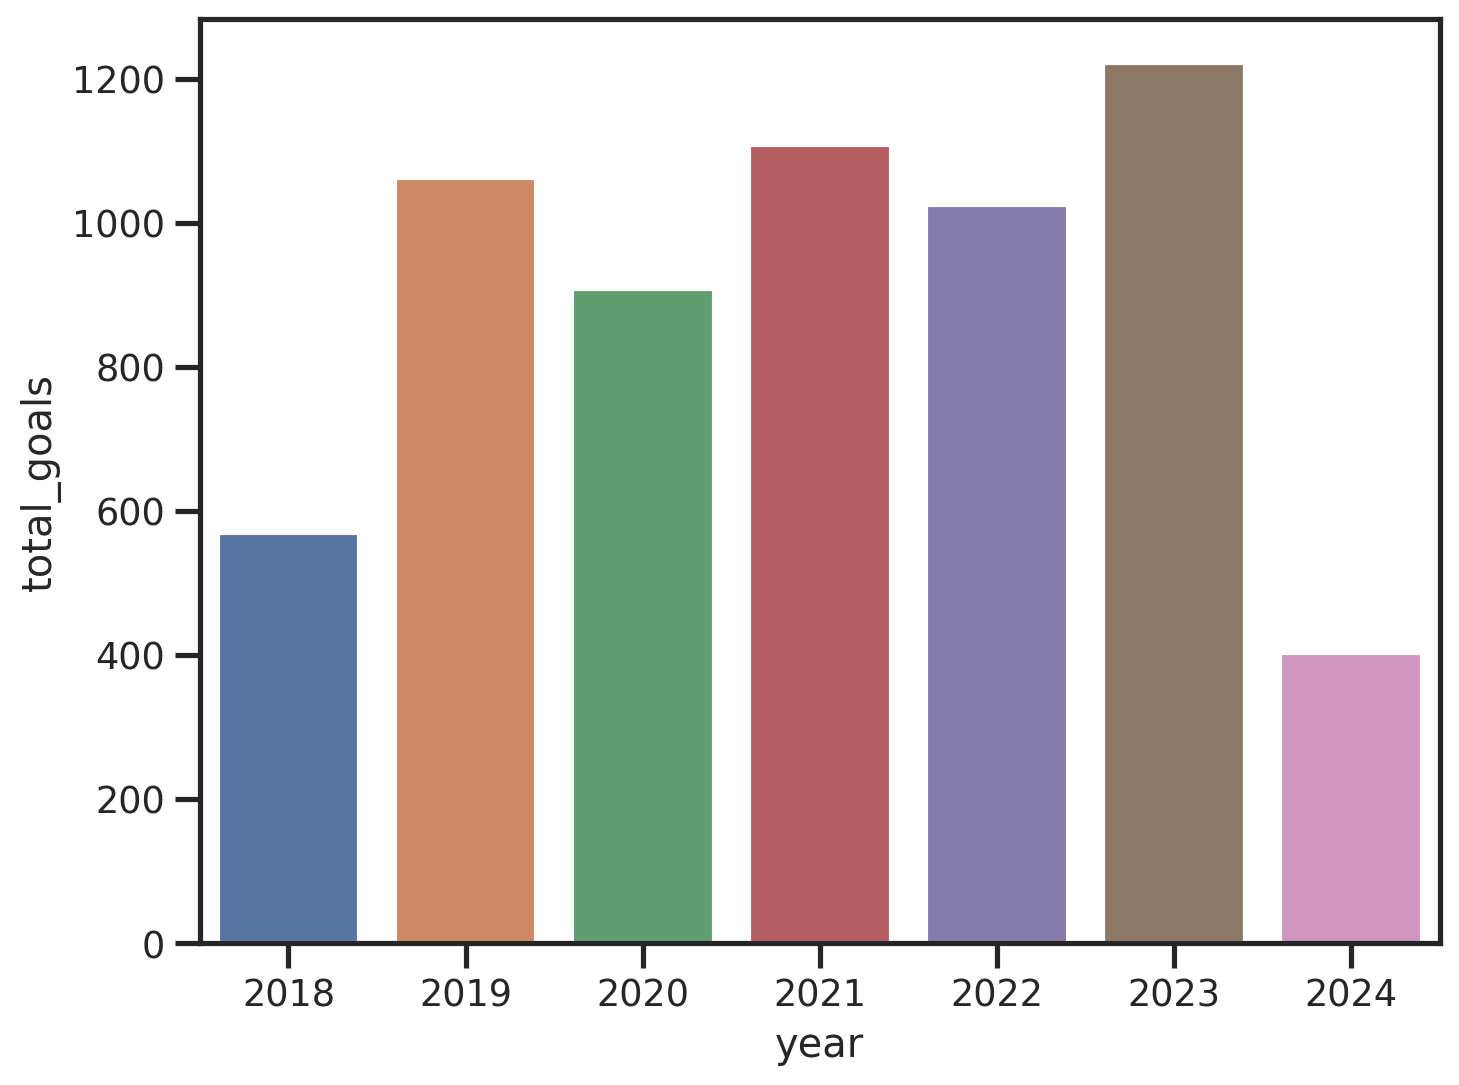

In [76]:
sns.barplot(x='year', y='total_goals', data=goals_per_year)

# Identifying Outliers and Handling Outliers

<font size="4">I will be identifying outliers by visualizing the data points using `seaborn.boxplot()`. 
   

In [77]:
matches.head(2)

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,formation,referee,sh,sot,fk,pkatt,season,team,total_goals,year
0,2023-08-12,12:30:00,Sat,Home,W,2,1,Nottingham Forest,0.8,1.2,...,4-3-3,Michael Oliver,15,7,0,0,2024,Arsenal,3,2023
1,2023-08-21,20:00:00,Mon,Away,W,1,0,Crystal Palace,2.0,1.0,...,4-3-3,David Coote,13,2,0,1,2024,Arsenal,1,2023


In [78]:
matches['xg'].describe()

count    4426.000000
mean        1.379530
std         0.814899
min         0.000000
25%         0.800000
50%         1.200000
75%         1.800000
max         7.000000
Name: xg, dtype: float64

In [79]:
matches.query("xg>4.5")['xg'].value_counts()

xg
4.6    3
5.9    2
7.0    1
5.2    1
4.7    1
4.8    1
Name: count, dtype: int64

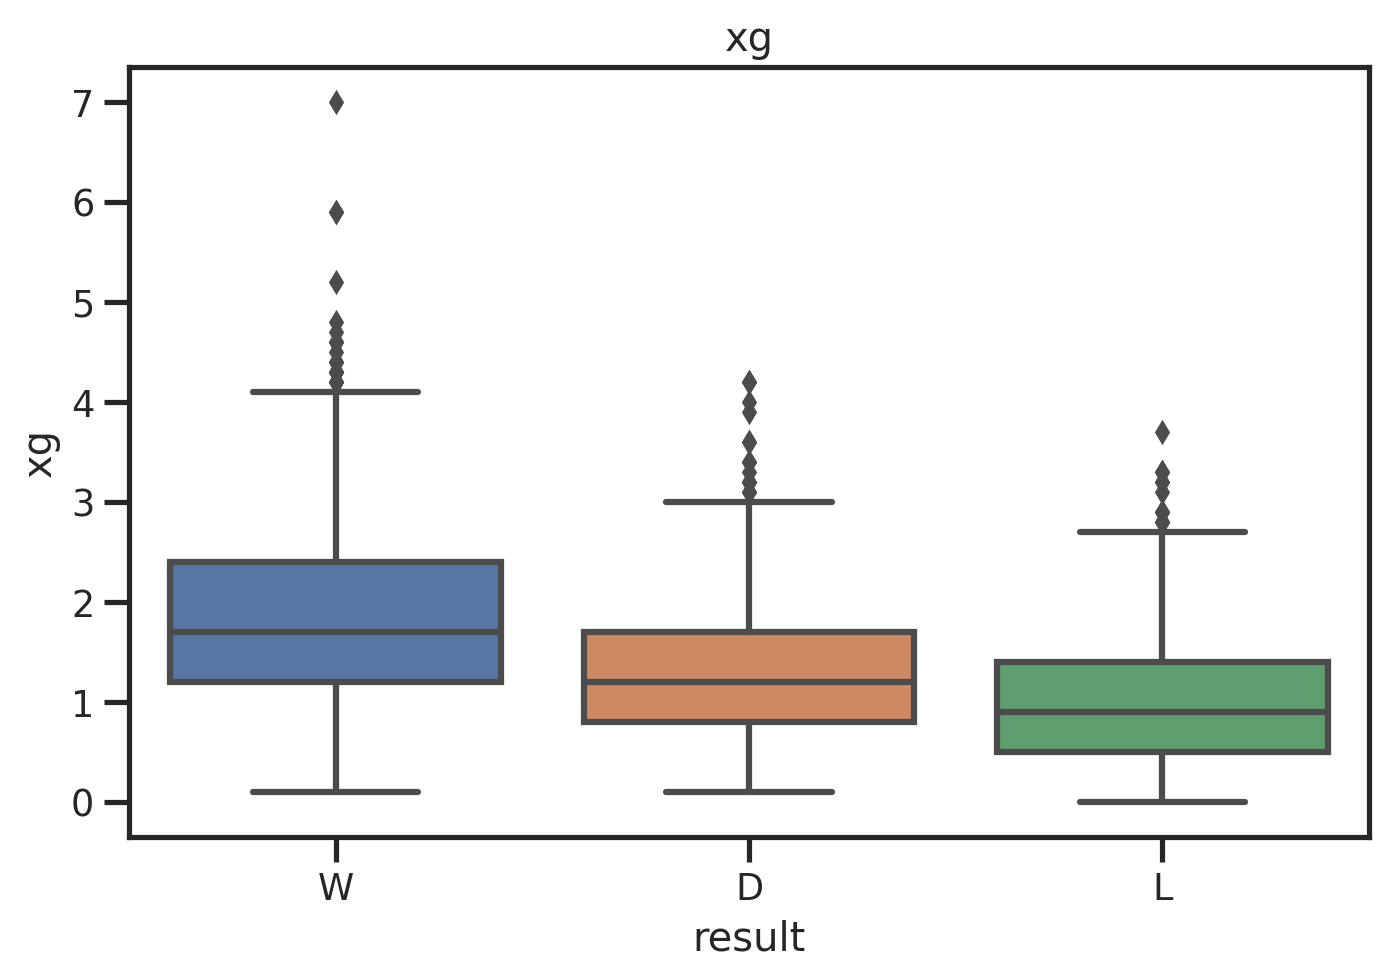

In [80]:
plot_boxplot(matches, 'xg', 'result')

In [81]:
matches.loc[matches['xg']>4.5, 'xg'] =  4.5

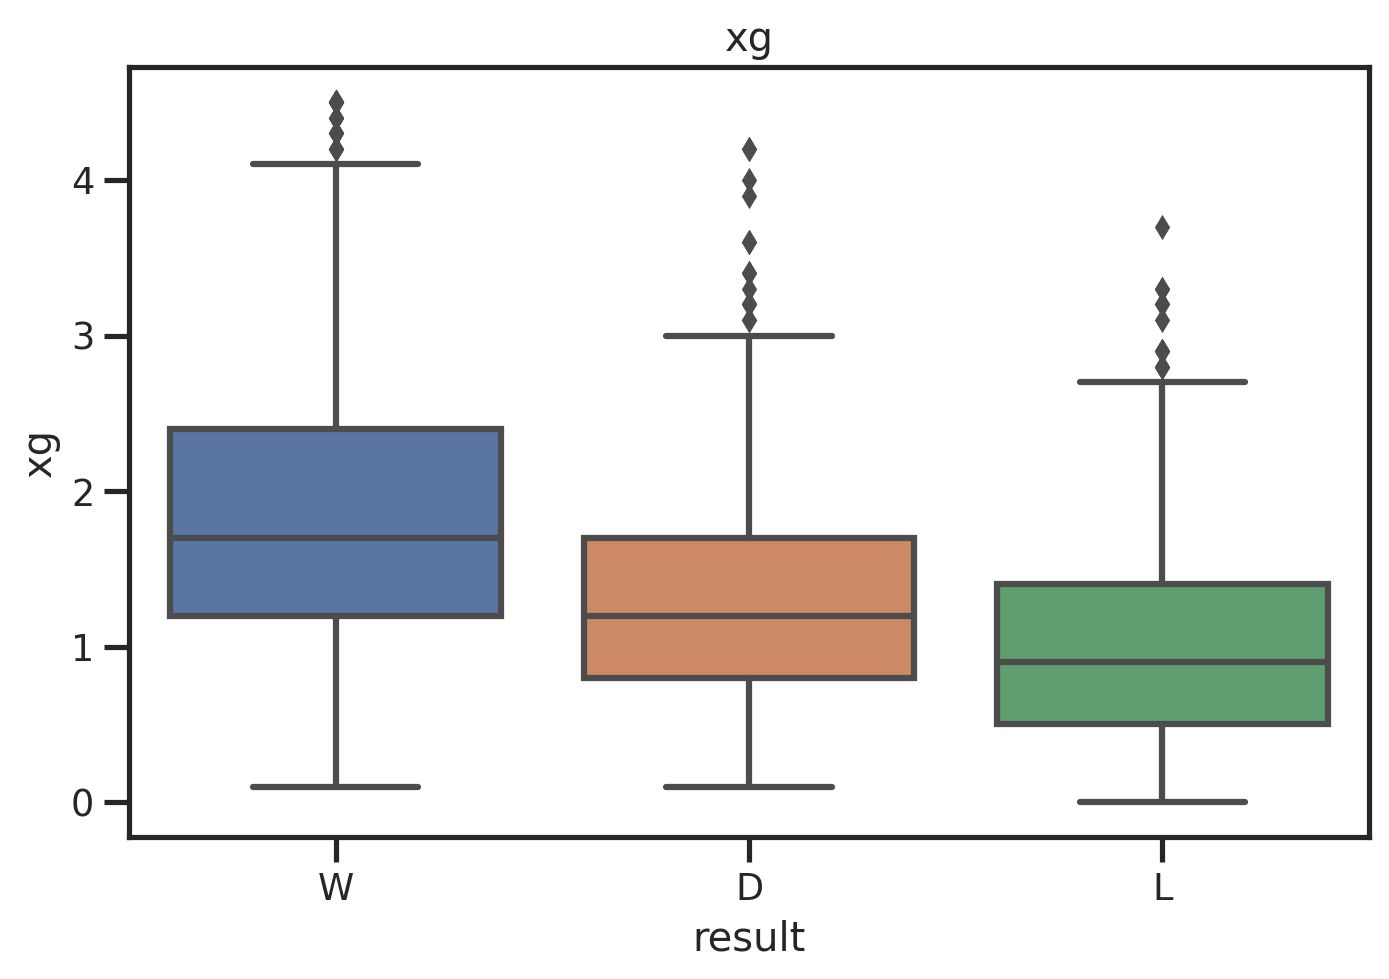

In [82]:
plot_boxplot(matches, 'xg', 'result')

In [83]:
matches.query("xg>4.5")['xg'].value_counts()

Series([], Name: count, dtype: int64)

In [84]:
matches.query("xga>4.5")['xga'].value_counts()

xga
4.6    3
5.9    2
7.0    1
5.2    1
4.7    1
4.8    1
Name: count, dtype: int64

In [85]:
matches.loc[matches['xga']>4.5, 'xga'] =  4.5

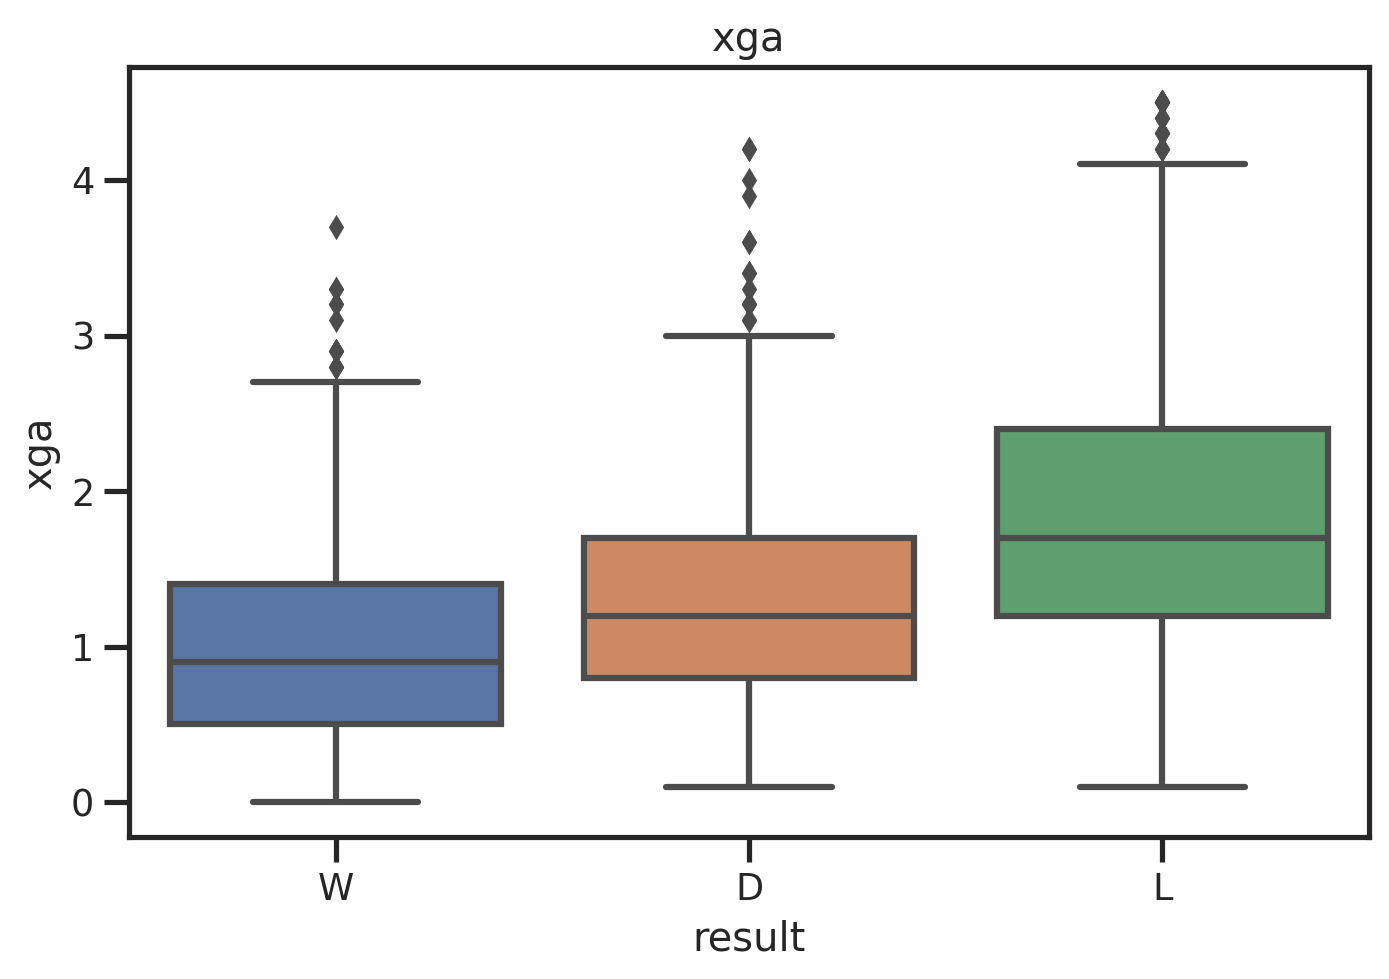

In [86]:
plot_boxplot(matches, 'xga', 'result')

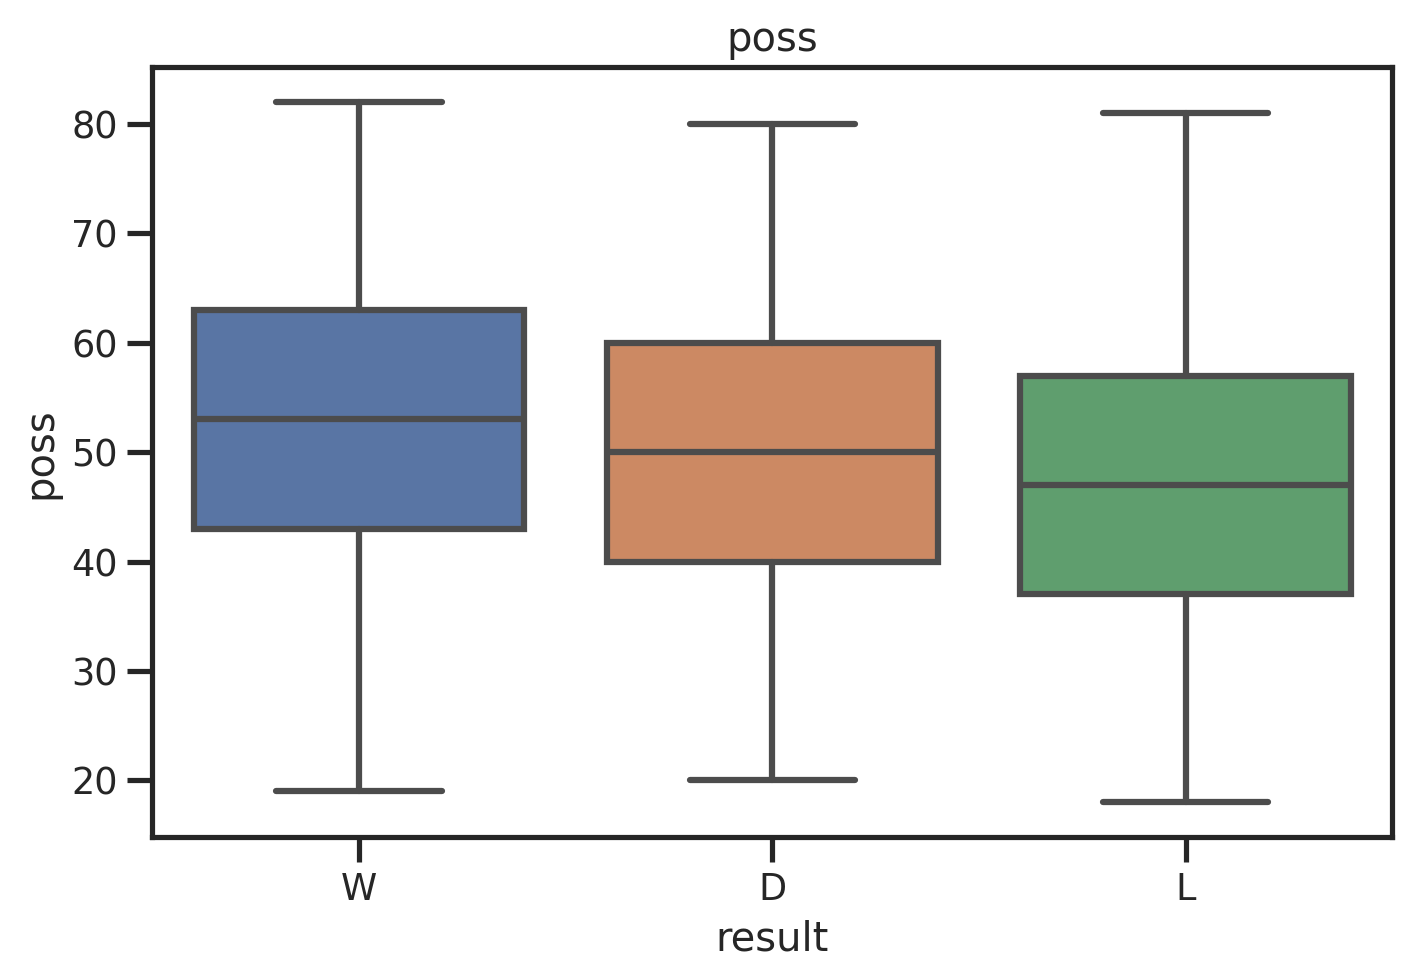

In [87]:
plot_boxplot(matches, 'poss', 'result')

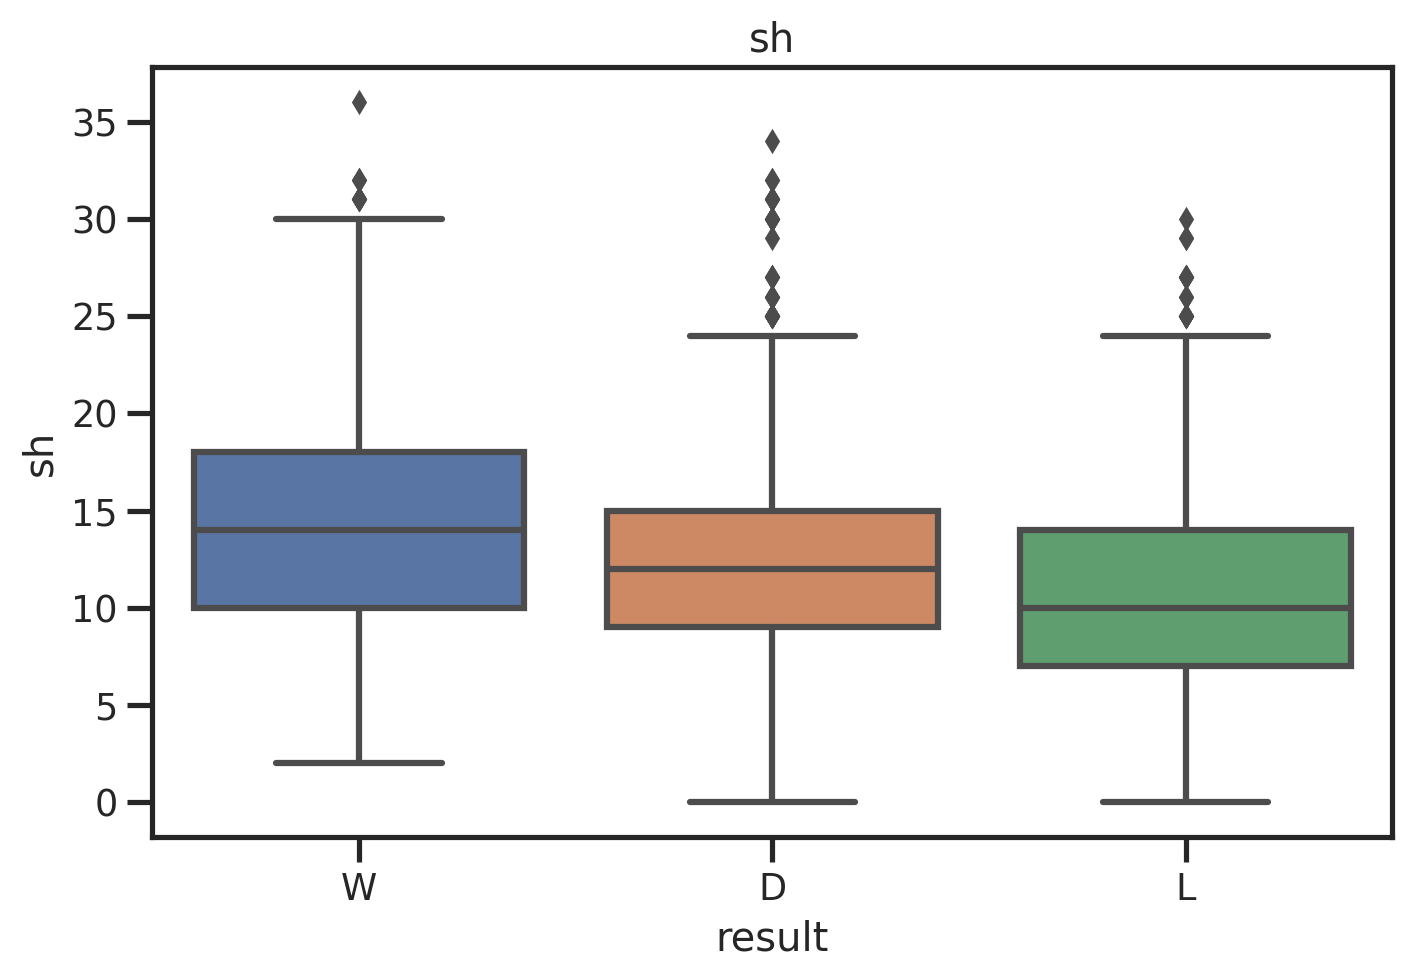

In [88]:
plot_boxplot(matches,'sh','result')

In [89]:
matches['sh'].describe()

count    4426.000000
mean       12.542702
std         5.506656
min         0.000000
25%         8.250000
50%        12.000000
75%        16.000000
max        36.000000
Name: sh, dtype: float64

In [90]:
matches.loc[matches['sh'] > 30, 'sh'] = 30

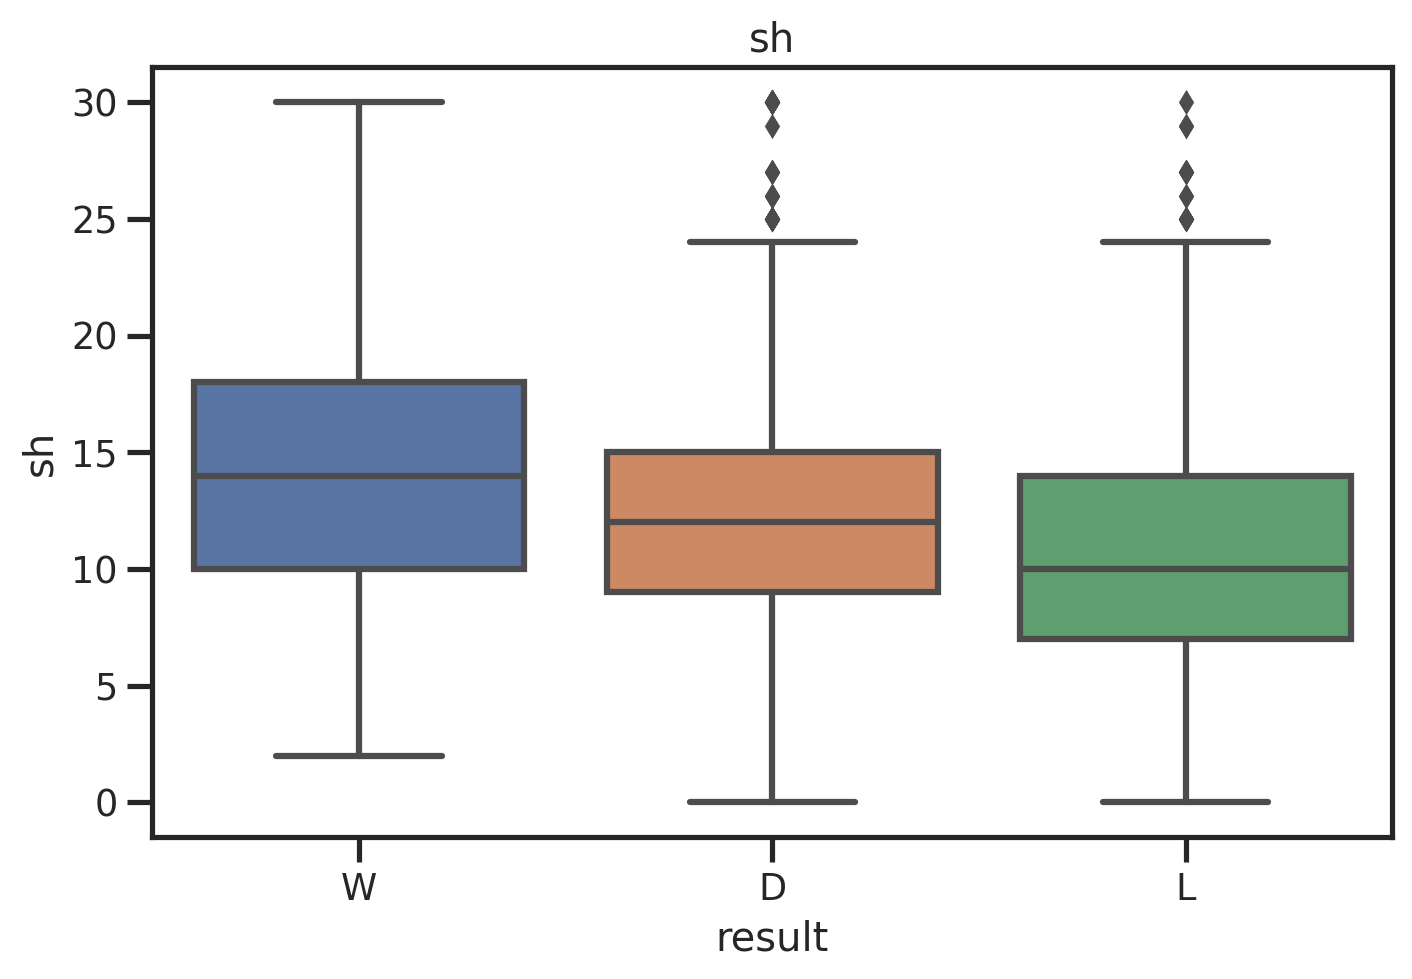

In [91]:
plot_boxplot(matches,'sh','result')

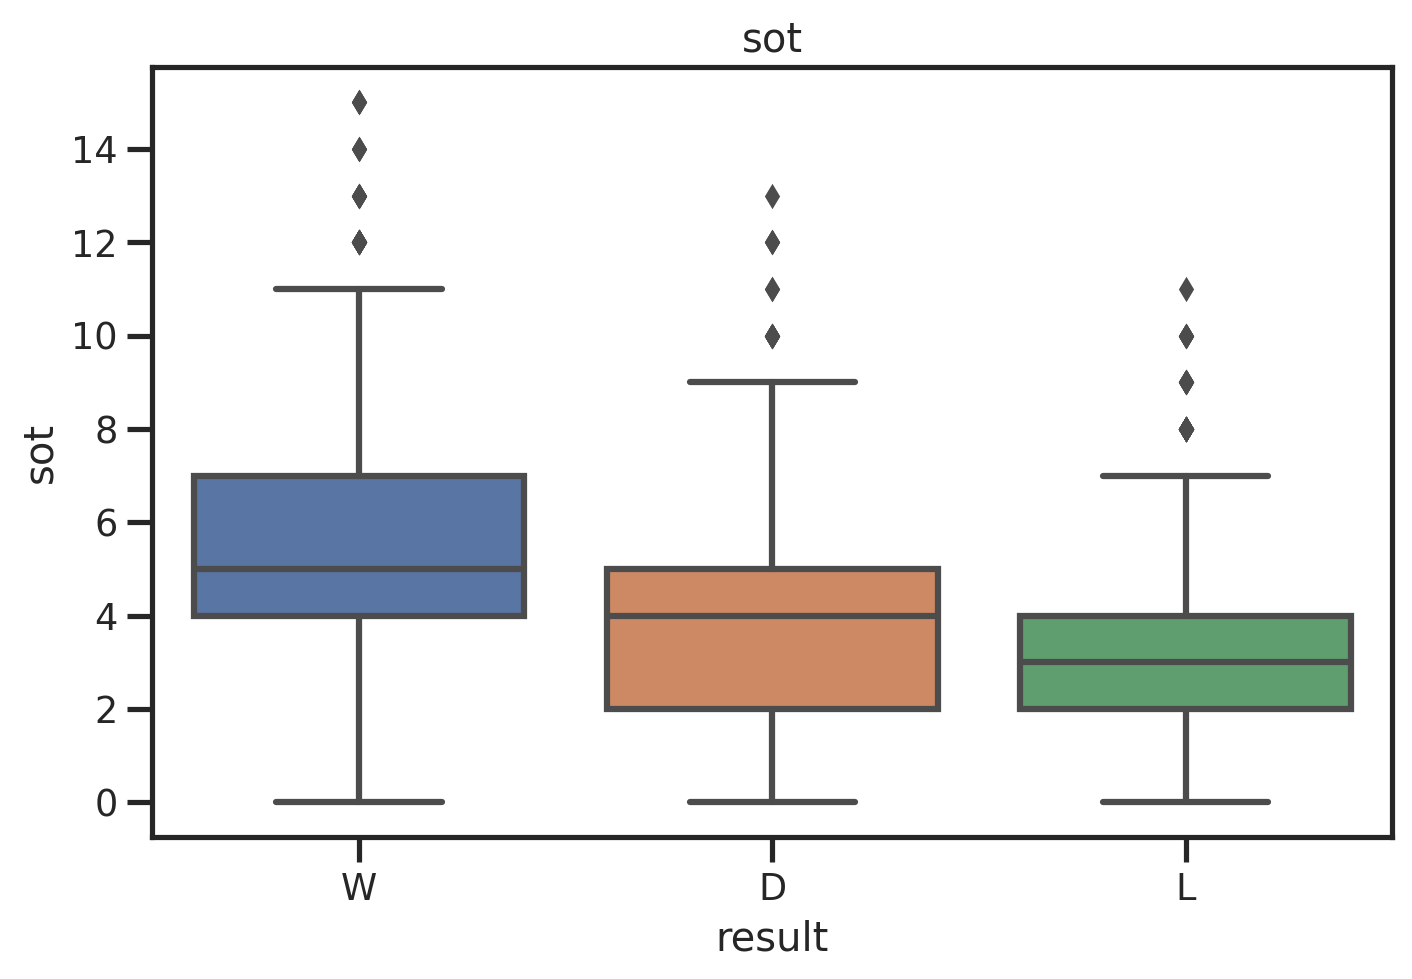

In [92]:
plot_boxplot(matches,'sot','result')

In [93]:
matches['sot'].describe()

count    4426.000000
mean        4.188432
std         2.440471
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        15.000000
Name: sot, dtype: float64

In [94]:
matches['sot'].quantile(0.99)

11.0

In [95]:
matches.loc[matches['sot']>matches['sot'].quantile(0.99), 'sot'] = matches['sot'].quantile(0.99)

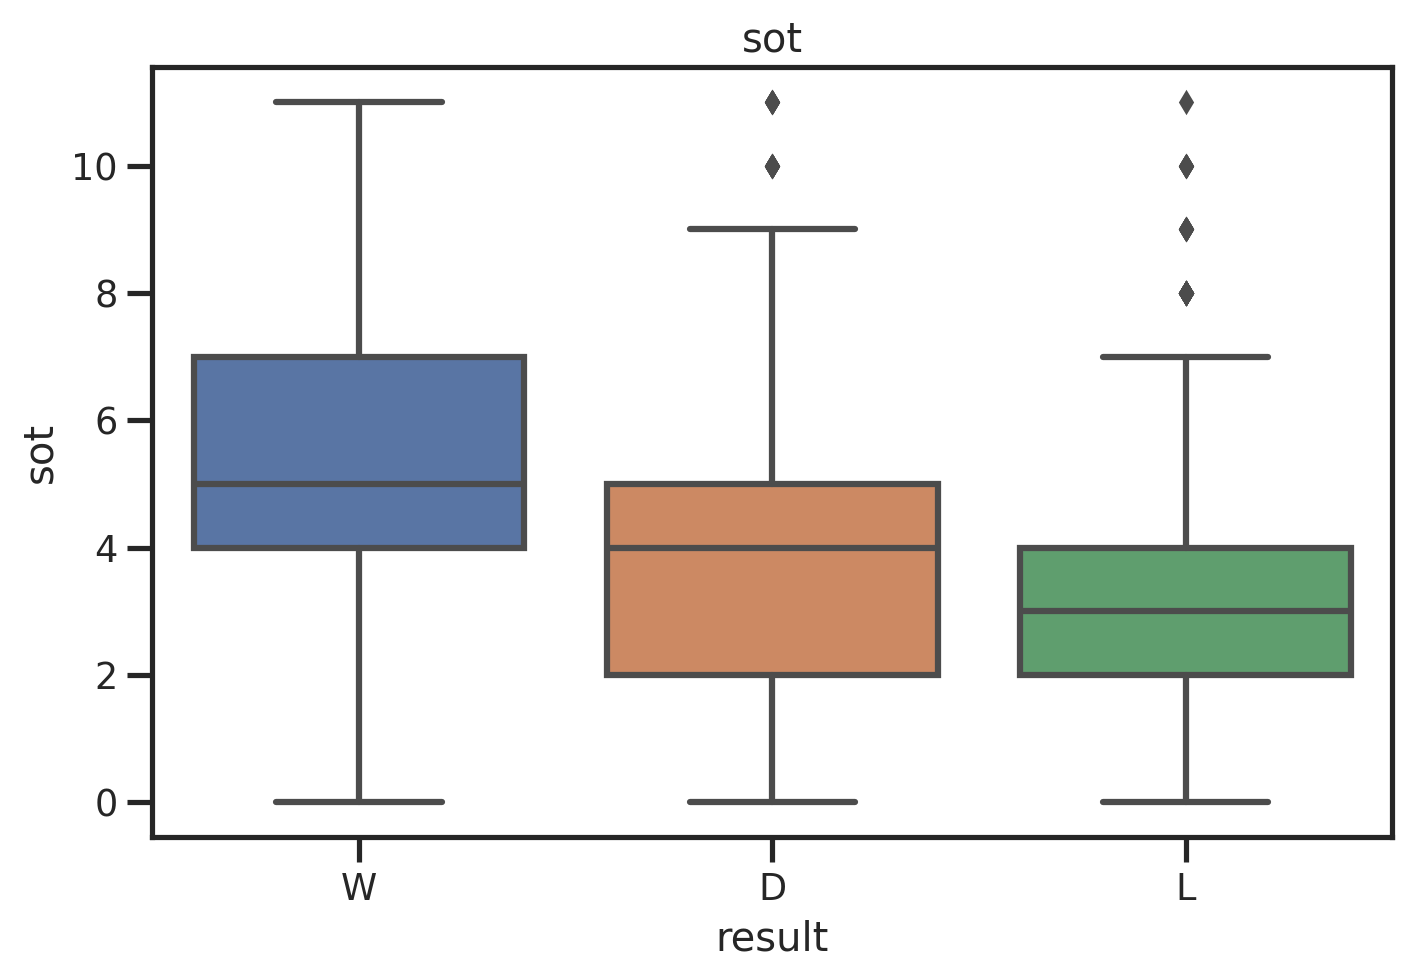

In [96]:
plot_boxplot(matches, 'sot', 'result')

In [97]:
matches['fk'].describe()

count    4426.000000
mean        0.443742
std         0.660849
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         4.000000
Name: fk, dtype: float64

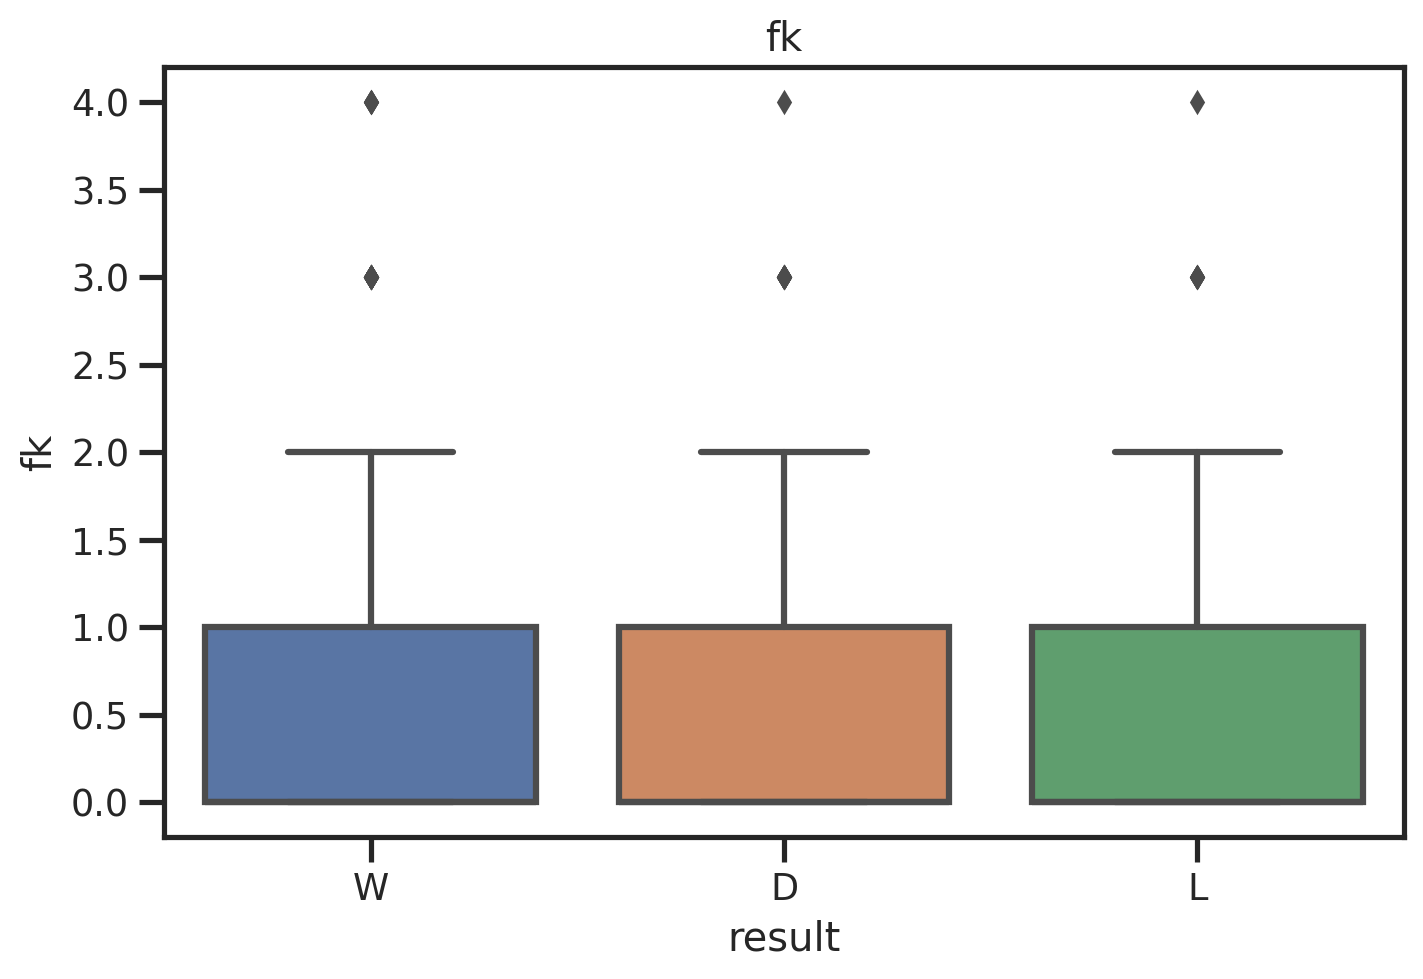

In [98]:
plot_boxplot(matches,'fk','result')

In [99]:
matches['fk'].value_counts()

fk
0    2831
1    1271
2     285
3      33
4       6
Name: count, dtype: int64

In [100]:
matches.loc[matches['fk']>matches['fk'].quantile(0.99),'fk'] = matches['fk'].quantile(0.99)

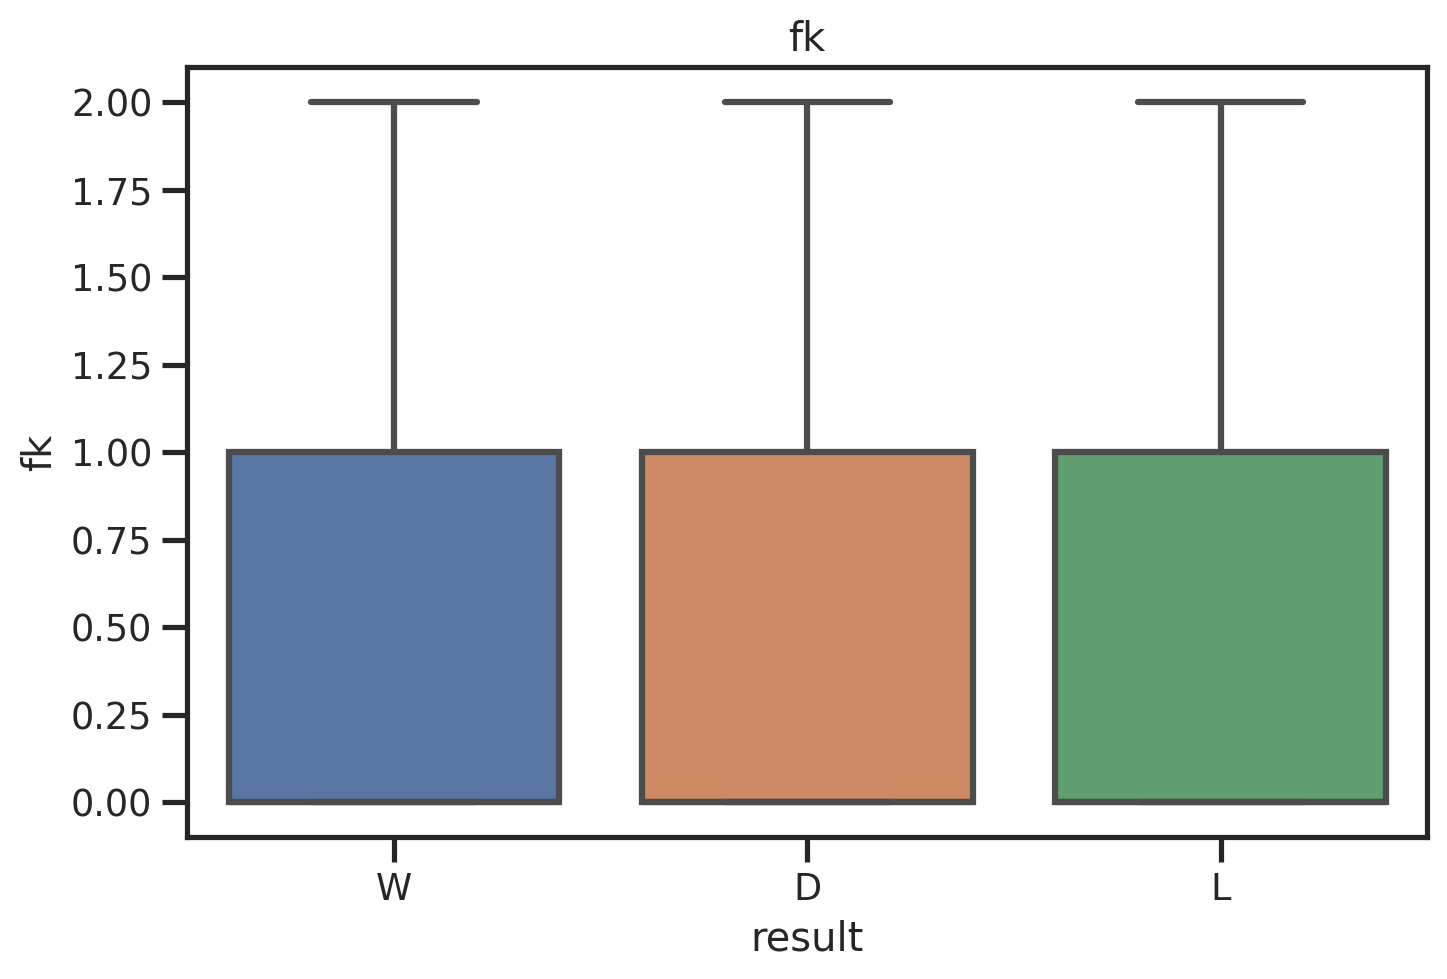

In [101]:
plot_boxplot(matches,'fk','result')

In [102]:
matches['pkatt'].describe()

count    4426.000000
mean        0.138048
std         0.369043
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: pkatt, dtype: float64

In [103]:
matches['pkatt'].value_counts()

pkatt
0    3852
1     538
2      35
3       1
Name: count, dtype: int64

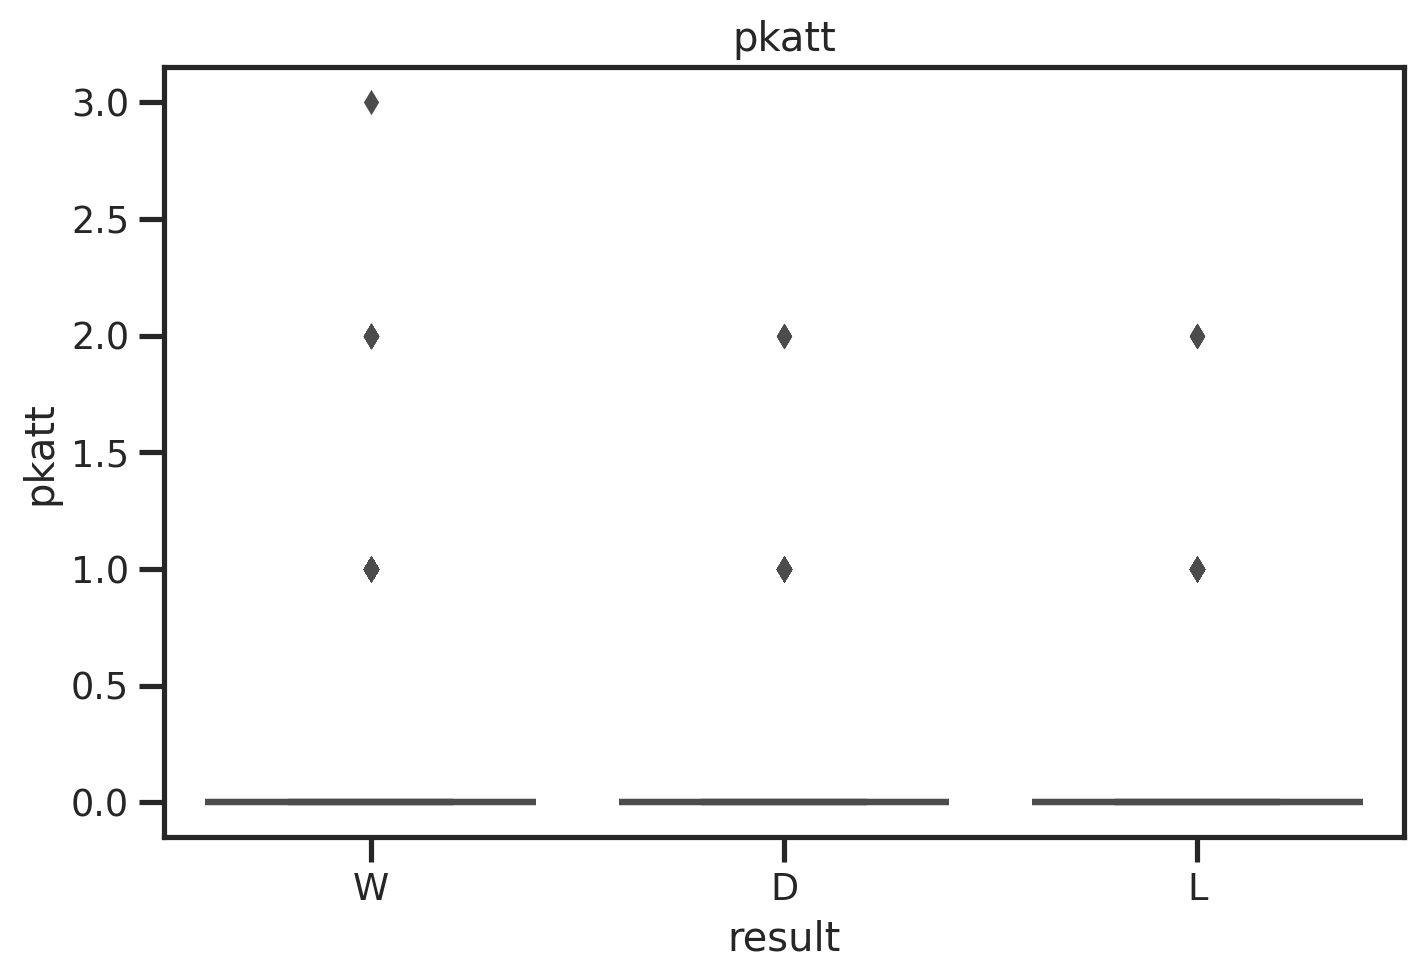

In [104]:
plot_boxplot(matches,'pkatt', 'result')

In [105]:
matches.loc[matches['pkatt']>1, 'pkatt'] = 1

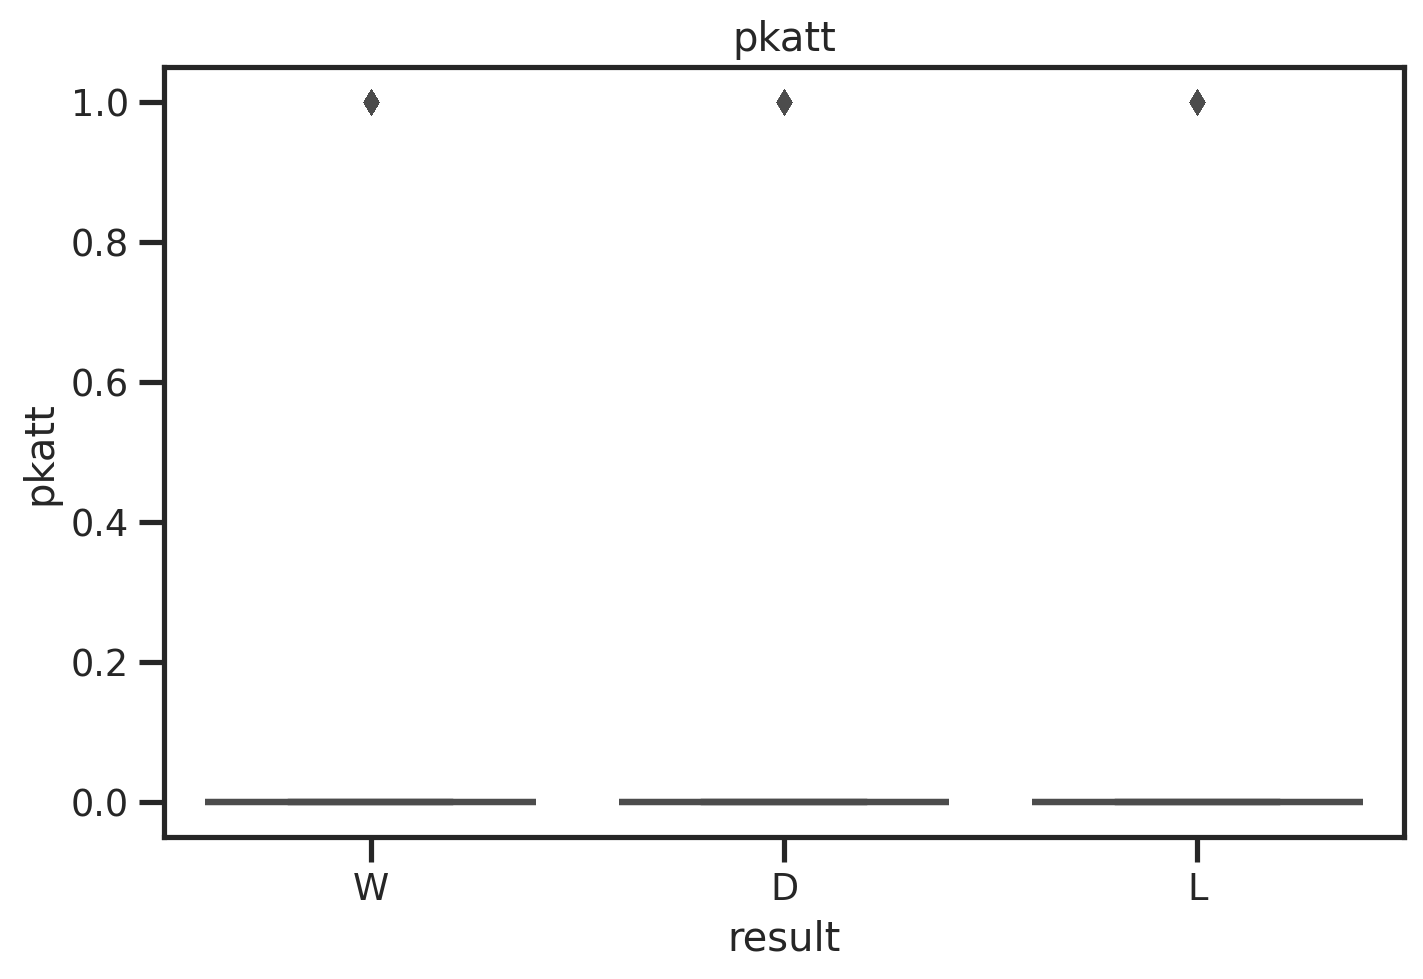

In [106]:
plot_boxplot(matches, 'pkatt', 'result')

In [107]:
matches

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,formation,referee,sh,sot,fk,pkatt,season,team,total_goals,year
0,2023-08-12,12:30:00,Sat,Home,W,2,1,Nottingham Forest,0.8,1.2,...,4-3-3,Michael Oliver,15,7,0,0,2024,Arsenal,3,2023
1,2023-08-21,20:00:00,Mon,Away,W,1,0,Crystal Palace,2.0,1.0,...,4-3-3,David Coote,13,2,0,1,2024,Arsenal,1,2023
2,2023-08-26,15:00:00,Sat,Home,D,2,2,Fulham,3.2,0.6,...,4-3-3,Paul Tierney,18,9,0,1,2024,Arsenal,4,2023
3,2023-09-03,16:30:00,Sun,Home,W,3,1,Manchester United,2.3,0.9,...,4-3-3,Anthony Taylor,17,5,0,0,2024,Arsenal,4,2023
4,2023-09-17,16:30:00,Sun,Away,W,1,0,Everton,1.0,0.3,...,4-3-3,Simon Hooper,13,4,0,0,2024,Arsenal,1,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,2019-04-13,12:30:00,Sat,Away,L,0,4,Tottenham Hotspur,0.8,2.5,...,5-4-1,Lee Mason,7,1,1,0,2019,Huddersfield Town,4,2019
4422,2019-04-20,15:00:00,Sat,Home,L,1,2,Watford,1.0,0.9,...,4-4-1-1,Roger East,13,3,1,0,2019,Huddersfield Town,3,2019
4423,2019-04-26,20:00:00,Fri,Away,L,0,5,Liverpool,0.2,3.1,...,4-1-4-1,Kevin Friend,5,1,0,0,2019,Huddersfield Town,5,2019
4424,2019-05-05,14:00:00,Sun,Home,D,1,1,Manchester United,1.0,1.8,...,4-3-3,Lee Mason,7,3,1,0,2019,Huddersfield Town,2,2019


## Feature Selection Features

In [108]:
matches['target'] = (matches['result']=='W').astype('int')

In [109]:
matches.drop(columns='result', inplace=True)

In [110]:
matches.drop(columns=['season', 'total_goals','year'], inplace=True)

In [111]:
categorical_feat = [col for col in matches.columns if matches[col].dtype=='O']
num_feat = [col for col in matches.columns if col not in categorical_feat][1:]

In [112]:
categorical_feat

['time', 'day', 'venue', 'opponent', 'captain', 'formation', 'referee', 'team']

In [113]:
matches.columns

Index(['date', 'time', 'day', 'venue', 'gf', 'ga', 'opponent', 'xg', 'xga',
       'poss', 'captain', 'formation', 'referee', 'sh', 'sot', 'fk', 'pkatt',
       'team', 'target'],
      dtype='object')

Text(0.5, 1.0, 'CORRELATION OF NUMERICAL FEATURES WITH TARGET')

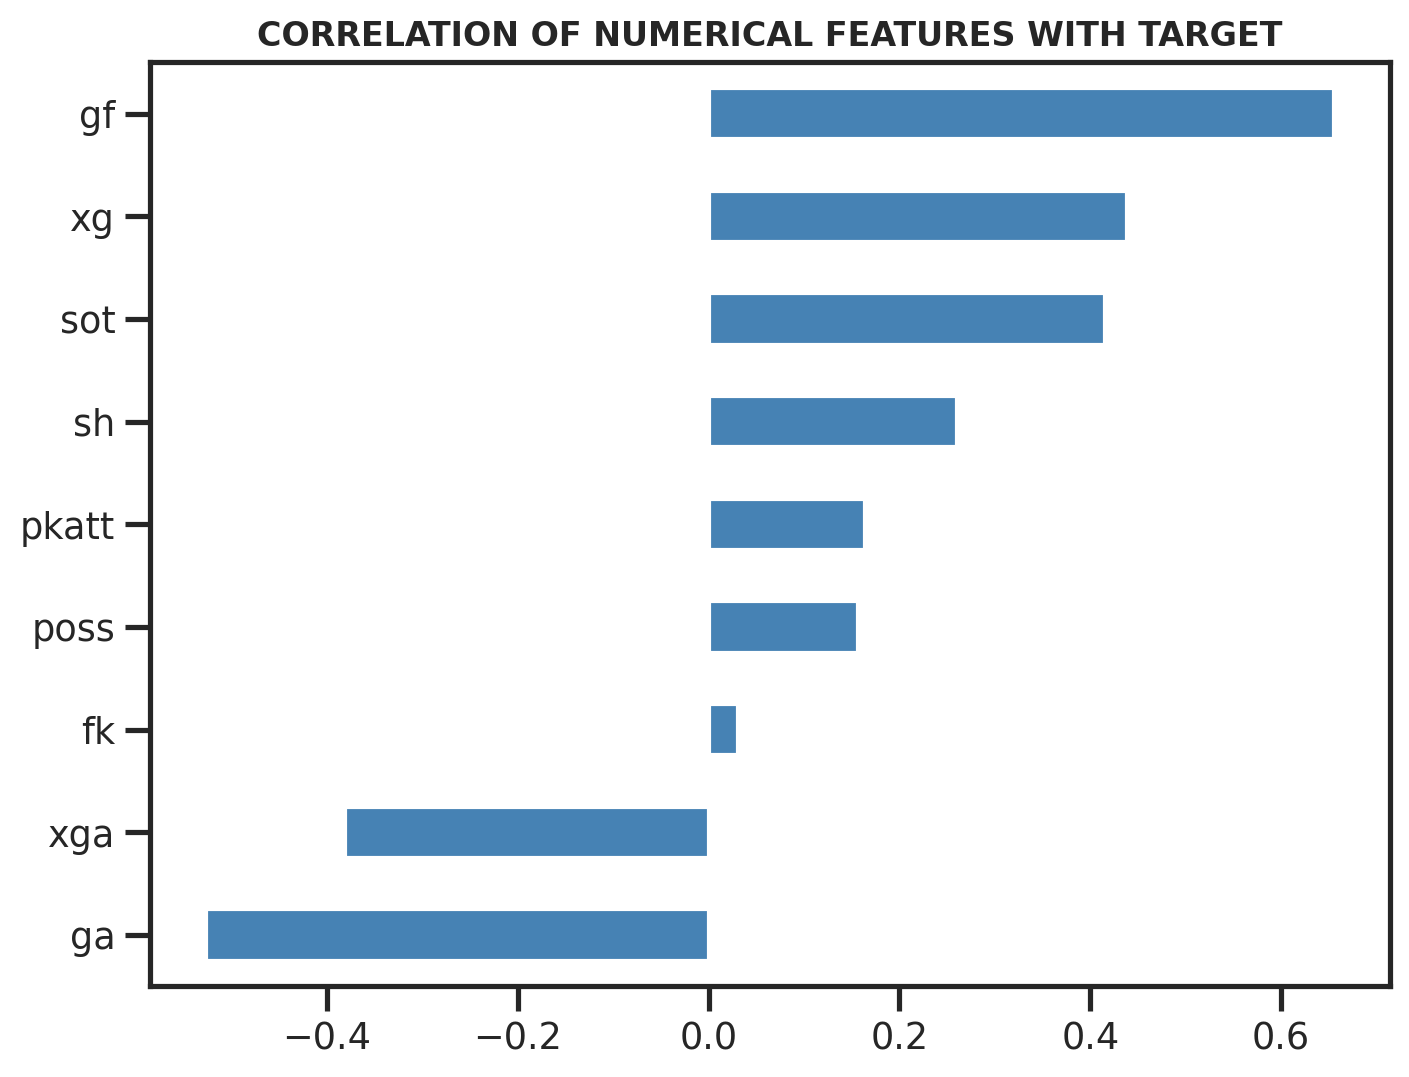

In [114]:
# feature correlation with  Target
matches[num_feat].corr()['target'].drop('target').sort_values(ascending=True).plot(kind='barh',color='steelblue');
plt.title('Correlation of numerical features with target'.upper(), weight='bold', fontsize=12)

In [115]:
cat_with_target = matches[categorical_feat + ['target']].phik_matrix()

interval columns not set, guessing: ['target']


Text(0.5, 1.0, 'CORRELATION PLOT OF CATEGORICAL FEATURES')

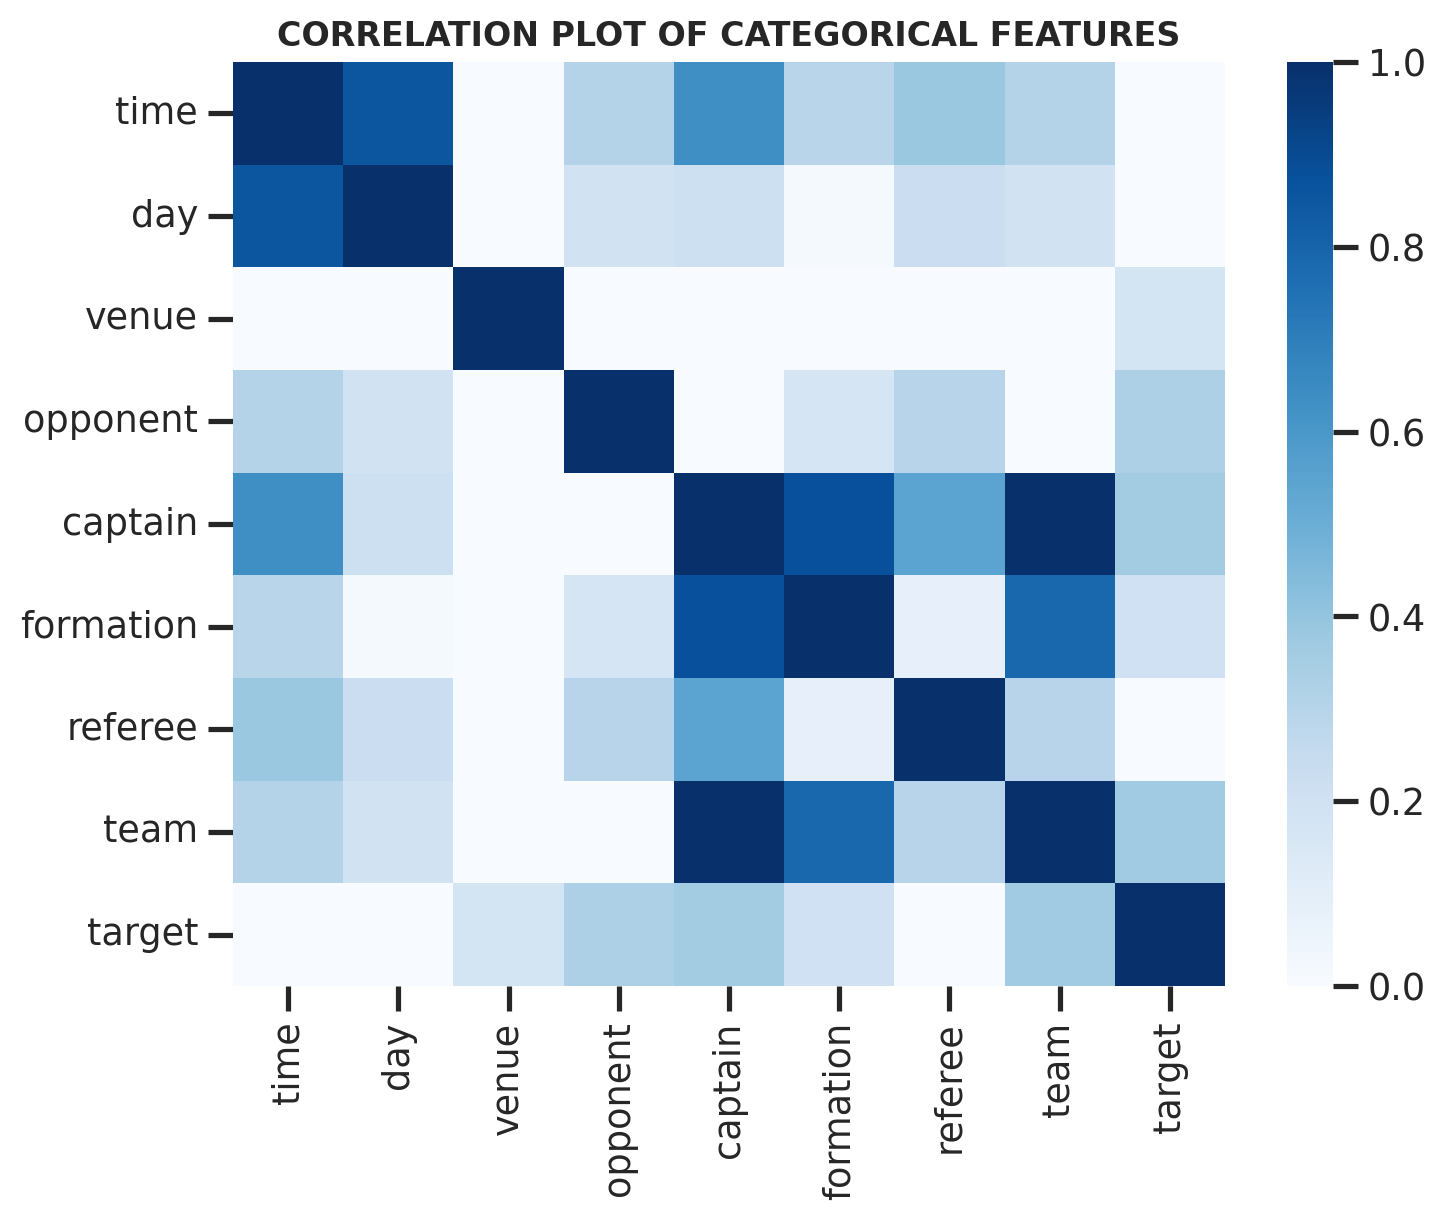

In [116]:
sns.heatmap(cat_with_target,cmap='Blues');
plt.title('Correlation plot of categorical features'.upper(), weight='bold', fontsize=12)

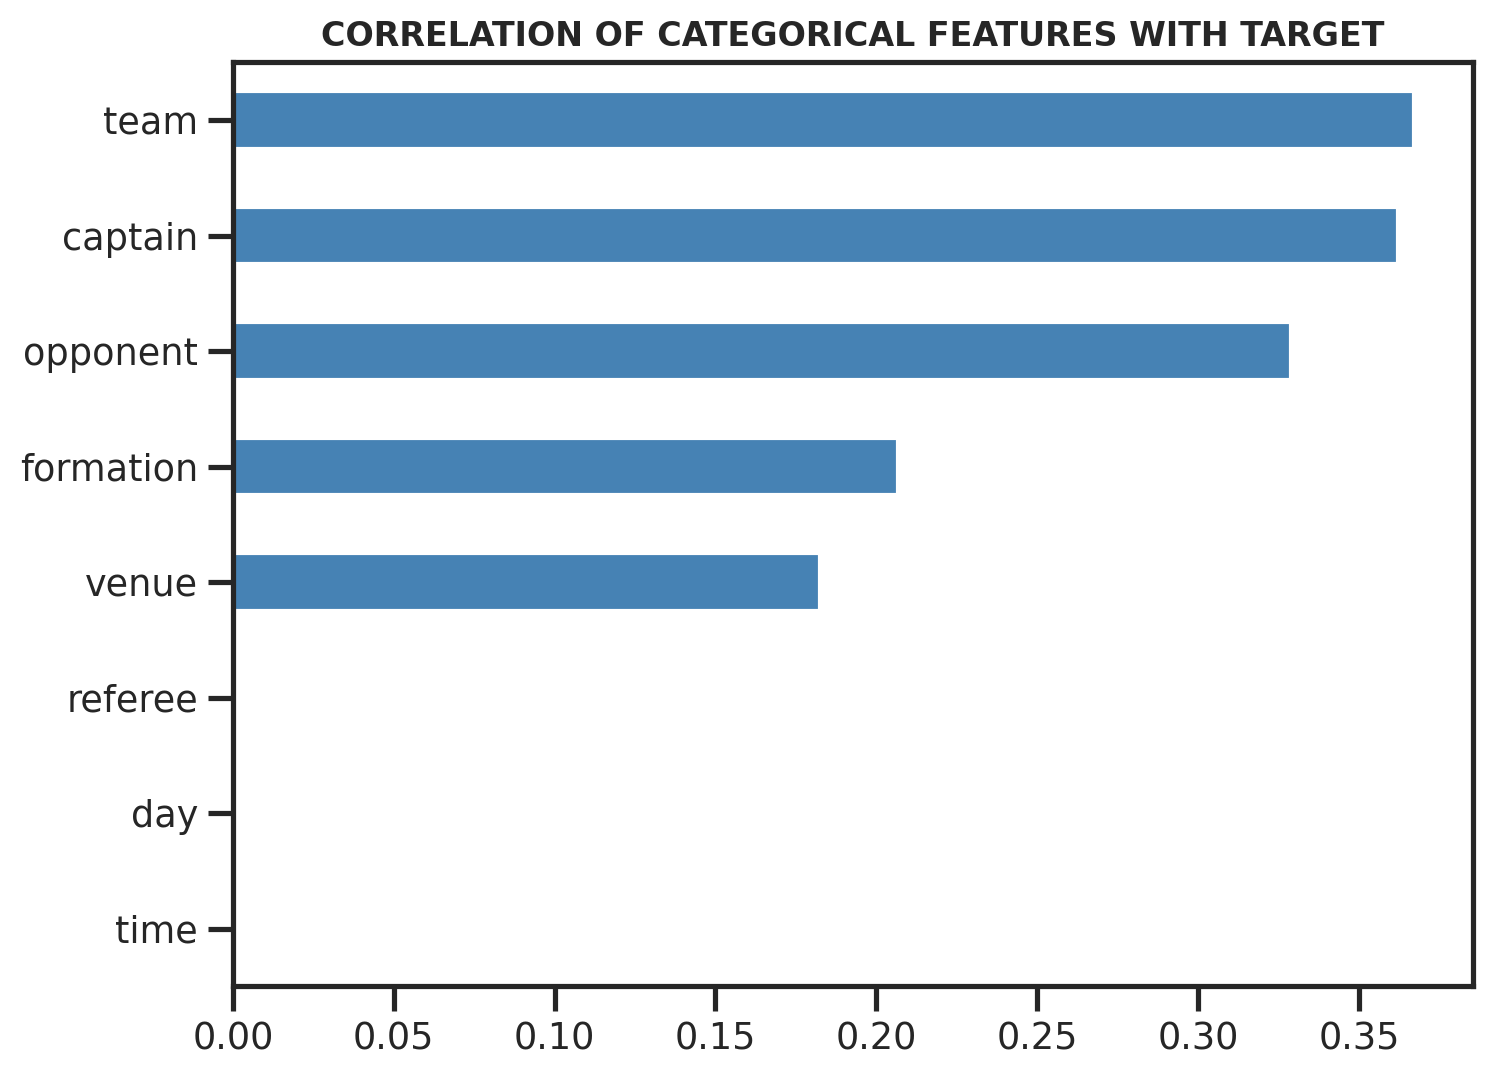

In [117]:
# feature correlation with  target
cat_with_target['target'].drop('target').sort_values(ascending=True).plot(kind='barh',color='steelblue');
plt.title('Correlation of categorical features with target'.upper(),weight='bold',fontsize=12);

In [118]:
features = ['venue','opponent', 'formation', 'team','captain','xg','xga','poss','sh','sot','fk','pkatt']

In [119]:
matches['date'].max()

Timestamp('2024-04-07 00:00:00')

In [120]:
X = matches[features]
y = matches['target']

In [121]:
seed = 1234 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

In [122]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3098, 12), (1328, 12), (3098,), (1328,))

In [123]:
for i in features:
    print(i)
    print(matches[i].nunique())

venue
2
opponent
28
formation
21
team
28
captain
203
xg
46
xga
46
poss
65
sh
31
sot
12
fk
3
pkatt
2


In [124]:
encoder = TargetEncoder(cols=['opponent','formation','team','captain']).fit(X_train, y_train) 
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [125]:
cols =  ['xg', 'xga', 'poss', 'sh', 'sot', 'fk', 'pkatt','opponent','formation','team','captain']

In [126]:
def preprocessor_pipe(num_features):
    numeric_features = num_features
    numeric_transformer = Pipeline(
        steps=[
            # its a good practice to do the polynomial/interaction feature generation before scaling.
            # ("poly_int", PolynomialFeatures(interaction_only=True, include_bias=False)),
            ("scaler", StandardScaler())
        ]
    ).set_output(transform='pandas')

    categorical_features = ['venue']
    categorical_transformer = Pipeline(
        steps=[
            ("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False, drop='if_binary')),
        ]
    ).set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [127]:
preprocessor = preprocessor_pipe(num_features=cols) 
Xtrainpreprocessed = preprocessor.fit_transform(X_train)
Xtestpreprocessed = preprocessor.transform(X_test)

In [128]:
seed = 1234
def model_selection(xtrain,xtest,ytrain,ytest):
    models = {
        'Logistic_regression':{
            'model':LogisticRegression(random_state=seed)
        },
        'random_forest':{
            'model':RandomForestClassifier(random_state=seed)
        },
        'gradient_boost':{
            'model':GradientBoostingClassifier(random_state=seed)
        },
        'histgradient_boost':{
            'model':HistGradientBoostingClassifier(random_state=seed)
        }
    }

    scores = []
    for model_name, config in models.items():
        start = time.time()
        config['model'].fit(xtrain, ytrain)
        y_pred = config['model'].predict(xtest) 
        train_score = config['model'].score(xtrain, ytrain)
        acc = accuracy_score(ytest, y_pred)
        precision_ = precision_score(ytest, y_pred)
        f1 = f1_score(ytest, y_pred)
        end = time.time()
        elasped_time = end - start
        scores.append({
            'model': model_name,
            'train_score':train_score,
            'accuracy_score':acc,
            'precision_score':precision_,
            'f1_score':f1,
            'time_taken':elasped_time})

    return pd.DataFrame(scores,columns=['model','train_score','accuracy_score','precision_score','f1_score','time_taken'])

In [129]:
all_features = model_selection(Xtrainpreprocessed, Xtestpreprocessed, y_train, y_test)

In [130]:
all_features

,model,train_score,accuracy_score,precision_score,f1_score,time_taken
0,Logistic_regression,0.800516,0.798946,0.790698,0.736946,1.214481
1,random_forest,1.000000,0.766566,0.778846,0.676409,0.968986
2,gradient_boost,0.843447,0.774849,0.768212,0.699497,0.524161
3,histgradient_boost,0.950613,0.765060,0.746781,0.690476,0.686909


I'm really interested in our the XGboost model will perform on this dataset.

However, I'm going to perform hyperparameter tunning using `hyperopt` and `MlFlow`.

I'm not going to track the other models as this is not a key objective for this project.


## Hyperparameter tunning on XGBoostClassifier

In [138]:
# Set tracking uri and set experiments
# mlflow.set_tracking_uri("http://127.0.0.1:8000")
mlflow.create_experiment('epl_match_winners', artifact_location="../mlruns")
mlflow.set_experiment("epl_match_winners")

RestException: BAD_REQUEST: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "experiments_name_key"
DETAIL:  Key (name)=(epl_match_winners) already exists.

[SQL: INSERT INTO experiments (name, artifact_location, lifecycle_stage, creation_time, last_update_time) VALUES (%(name)s, %(artifact_location)s, %(lifecycle_stage)s, %(creation_time)s, %(last_update_time)s) RETURNING experiments.experiment_id]
[parameters: {'name': 'epl_match_winners', 'artifact_location': '/home/adedolapo/MLOps/../mlruns', 'lifecycle_stage': 'active', 'creation_time': 1714924334701, 'last_update_time': 1714924334701}]
(Background on this error at: https://sqlalche.me/e/20/gkpj)

In [139]:
train = xgb.DMatrix(Xtrainpreprocessed, label=y_train)
valid = xgb.DMatrix(Xtestpreprocessed, label=y_test)

In [148]:
Xtestpreprocessed

,xg,xga,poss,sh,sot,fk,pkatt,opponent,formation,team,captain,venue_Home
2634,-1.202452,0.769815,0.614550,-0.102369,-0.900346,0.911276,-0.380609,1.133894,-0.302282,-0.269046,-0.118749,1.0
2400,1.629741,-1.082476,1.001799,-0.102369,0.351197,0.911276,-0.380609,0.400838,0.435089,0.920972,1.362594,1.0
4130,0.521492,-0.712018,1.311599,2.626887,0.768378,0.911276,-0.380609,-0.128604,-1.113133,-0.223966,-0.655853,1.0
1086,0.152075,-1.205962,1.156699,0.807383,-0.483165,0.911276,-0.380609,1.007790,1.211413,-0.269046,-0.763398,0.0
85,1.506602,0.028898,1.543949,3.172738,0.351197,0.911276,-0.380609,-0.997778,-0.727277,2.514696,1.078112,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4330,-0.586758,0.893301,-0.934449,-0.648220,-0.065984,-0.685519,-0.380609,0.400838,-1.987289,-0.584313,-0.761080,0.0
1637,-0.709896,-1.329449,1.079249,-0.648220,-0.900346,-0.685519,-0.380609,1.326257,0.435089,0.022804,0.158260,1.0
1775,-1.448729,1.016787,-2.251099,-1.194072,-1.317527,-0.685519,-0.380609,-0.997778,-2.936773,-0.223966,-0.655853,1.0
2950,1.752880,1.263759,1.001799,1.171284,1.602740,0.911276,-0.380609,0.388038,1.211413,2.514696,1.982644,0.0


In [189]:
def objective(params):

    # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
    mlflow.xgboost.autolog(silent=True)

    with mlflow.start_run():
        mlflow.set_tag("Developer", "Dolapo Adebo")
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        auc = roc_auc_score(y_test, y_pred)
        mlflow.log_metric("auc",auc)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'loss': -auc, 'status': STATUS_OK}

In [190]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'lambda': hp.loguniform('lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': seed,
}


In [191]:

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

[0]	validation-auc:0.77823                            
[1]	validation-auc:0.78499                            
[2]	validation-auc:0.79555                            
[3]	validation-auc:0.80128                            
[4]	validation-auc:0.80440                            
[5]	validation-auc:0.81148                            
[6]	validation-auc:0.81293                            
[7]	validation-auc:0.81307                            
[8]	validation-auc:0.81612                            
[9]	validation-auc:0.81729                            
[10]	validation-auc:0.81895                           
[11]	validation-auc:0.82146                           
[12]	validation-auc:0.82307                           
[13]	validation-auc:0.82291                           
[14]	validation-auc:0.82539                           
[15]	validation-auc:0.82651                           
[16]	validation-auc:0.82757                           
[17]	validation-auc:0.82891                           
[18]	valid

In [192]:
best_result['max_depth']

{'lambda': 0.01039689089040307,
 'learning_rate': 0.11176509411494115,
 'max_depth': 4.0,
 'min_child_weight': 0.46724858797367846}

In [221]:
params = {'lambda': 0.01039689089040307,
    'learning_rate': 0.11176509411494115,
    'max_depth': int(4.0),
    'min_child_weight': 0.46724858797367846,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': seed}

### using this parameters to cross validate the model

In [222]:
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

[0]	validation-auc:0.77913
[1]	validation-auc:0.79347
[2]	validation-auc:0.79821
[3]	validation-auc:0.80628
[4]	validation-auc:0.80650
[5]	validation-auc:0.81267
[6]	validation-auc:0.81756
[7]	validation-auc:0.81877
[8]	validation-auc:0.82009
[9]	validation-auc:0.82360
[10]	validation-auc:0.82355
[11]	validation-auc:0.82610
[12]	validation-auc:0.82916
[13]	validation-auc:0.83058
[14]	validation-auc:0.83050
[15]	validation-auc:0.83247
[16]	validation-auc:0.83574
[17]	validation-auc:0.83943
[18]	validation-auc:0.84170
[19]	validation-auc:0.84199
[20]	validation-auc:0.84379
[21]	validation-auc:0.84572
[22]	validation-auc:0.84540
[23]	validation-auc:0.84630
[24]	validation-auc:0.84701
[25]	validation-auc:0.84713
[26]	validation-auc:0.84803
[27]	validation-auc:0.84823
[28]	validation-auc:0.84789
[29]	validation-auc:0.84899
[30]	validation-auc:0.84994
[31]	validation-auc:0.85040
[32]	validation-auc:0.85046
[33]	validation-auc:0.85137
[34]	validation-auc:0.85122
[35]	validation-auc:0.85157
[3

In [223]:
predicts= booster.predict(valid)

In [224]:
predicts

array([0.05107754, 0.96073127, 0.08827252, ..., 0.0189833 , 0.906083  ,
       0.00766393], dtype=float32)